In [2]:
import os
import yaml
import sys
import math
import argparse
import pickle
import xarray as xr
import numpy as np
import pandas as pd 
import random
import sys
sys.path.append(r"C:\Users\Administrator\Desktop\code\LSTM\LSTM")
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from utils.utils import Util

def load_config(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config
# 数据预准备函数
def data_preparation(file_path, target_var, var_list, missing_values):
    # 读取nc文件
    data = xr.open_dataset(file_path)

    # 将lat坐标轴从小到大排列并选择特定区域
    data = data.sortby('lat')

    # 提取起始时间和结束时间并转化为datatime对象
    end_time = pd.to_datetime(data.time.values[-1])

    # 创建三个新的变量：Longitude, Latitude, DOY
    longitude = xr.DataArray(np.zeros(data[target_var].shape), 
                            dims=data[target_var].dims, 
                            coords=data[target_var].coords)
    latitude = xr.DataArray(np.zeros(data[target_var].shape), 
                            dims=data[target_var].dims, 
                            coords=data[target_var].coords)
    doy = xr.DataArray(np.zeros(data[target_var].shape), 
                    dims=data[target_var].dims, 
                    coords=data[target_var].coords)

    # 更新 DOY 变量
    for i in range(data.time.shape[0]):
        timestamp = pd.Timestamp(data.time[i].values)
        doy[i, :, :] = Util.calculate_hours_since_year_start(timestamp)

    # 更新 Longitude 和 Latitude 变量
    for i in range(data.lon.shape[0]):
        longitude[:, :, i] = data.lon[i]
    for i in range(data.lat.shape[0]):
        latitude[:, i, :] = data.lat[i]

    # 将新的变量添加到数据集中
    data = data.assign(Longitude=longitude, Latitude=latitude, DOY=doy)

    # 只提取var_list中的变量，如果var_list中包含新添加的变量，则它们也会被包括
    data = data[var_list]

    # 质量控制
    # MYD13A1:有效值-2000 to 10000，其他设置为0
    data.NDVI.values = np.where((data.NDVI.values < -2000) | (data.NDVI.values > 10000), np.nan, data.NDVI.values)
    data.EVI.values = np.where((data.EVI.values < -2000) | (data.EVI.values > 10000), np.nan, data.EVI.values)
    # MCD11A1:有效值7500 to 65535 
    data.LST_Day_1km.values = np.where((data.LST_Day_1km.values < 7500) | (data.LST_Day_1km.values > 65535), np.nan, data.LST_Day_1km.values)
    data.LST_Night_1km.values = np.where((data.LST_Night_1km.values < 7500) | (data.LST_Night_1km.values > 65535), np.nan, data.LST_Night_1km.values)
    # MCD43C3：有效值 0 到 32766
    MCD43C3_Var = ['Albedo_BSA_Band1','Albedo_BSA_Band2','Albedo_BSA_Band3','Albedo_BSA_Band4','Albedo_BSA_Band5','Albedo_BSA_Band6','Albedo_BSA_Band7','Albedo_BSA_vis','Albedo_BSA_nir','Albedo_BSA_shortwave'\
                   ,'Albedo_WSA_vis','Albedo_WSA_nir','Albedo_WSA_shortwave','Albedo_WSA_Band1','Albedo_WSA_Band2','Albedo_WSA_Band3','Albedo_WSA_Band4','Albedo_WSA_Band5','Albedo_WSA_Band6','Albedo_WSA_Band7']
    #循环遍历所有变量      
    for var in MCD43C3_Var:
        data[var].values = np.where((data[var].values < 0) | (data[var].values > 32766), np.nan, data[var].values)
    # 使用 missing_values 字典辨别缺失值
    for var, missing_val in missing_values.items():
        if var in data:
            data[var] = data[var].where(data[var] != missing_val, np.nan)
    data = data.transpose('time', 'lon', 'lat')
    return data


# 标准化函数,考虑0值在内
def vars_normalization(data):
    '''
    对所有数据不同通道标准化，保存每个变量的标准化系数, data以nc格式操作
    排除NaN值
    '''
    means_list = []
    std_list = []
    normalized_ds = data.copy()

    # 针对每个变量单独计算均值和标准差，并进行标准化
    for var in data.data_vars:
        mean = data[var].mean(dim=('time', 'lon', 'lat'), skipna=True)
        std = data[var].std(dim=('time', 'lon', 'lat'), skipna=True)

        normalized_ds[var] = (data[var] - mean) / std

        means_list.append(mean.values)
        std_list.append(std.values)

    return normalized_ds, means_list, std_list

def split_data_random_without_filling(data_point, time_step):
    """
    提取time_step+1步长
    """
    samples = []
    valid_indices = np.where(~np.isnan(data_point[:, 0]) & (data_point[:, 0] != 0))[0]

    # 跳过开始和结束时间不够的点
    valid_indices = valid_indices[valid_indices >= time_step]
    valid_indices = valid_indices[valid_indices < data_point.shape[0] - 1]

    for idx in valid_indices:
        sample = data_point[idx - time_step: idx + 1]  # 提取 time_step + 1 个时间点
        samples.append(sample)

    samples = np.array(samples)
    return samples

def area_split_random_without_filling(data, file_path=None, time_step=60):
    '''
    处理所有数据点，并保存成批次。
    :param area_data: 原始xarray数据集
    :param MinMaxNormalization_data: 经过最小-最大标准化的数据
    :param file_path: 保存文件的路径
    :param time_step: 时间步长
    '''
    batch_count = 0
    file_index = 0
    x = []  # 存储所有样本

    # 遍历每个点,先经度后纬度
    for i in range(data.lon.shape[0]):
        for j in range(data.lat.shape[0]):            
            # 提取并处理数据
            point_data = data.isel(lon=i, lat=j).to_array().values
            point_data = np.transpose(point_data, (1, 0))
            samples = split_data_random_without_filling(point_data, time_step)
            x.extend(samples)
            
            # 每处理500个点位，保存一次数据
            batch_count += 1
            if batch_count >= 500:
                # 转换为numpy数组并保存
                np.save(file_path + f"\\data_batch_{file_index}.npy", np.array(x))

                # 重置列表和计数器
                x = []
                batch_count = 0
                file_index += 1
                print(f"已处理{i * data.lat.shape[0] + j}个点位")

    # 保存最后一个批次（如果有）
    if x:
        np.save(file_path + f"\\data_batch_{file_index}.npy", np.array(x))

In [3]:
def main(args):
    model_argu = load_config(args.model_config_path)
    missing_values = load_config(args.vars_config_path)
    data_argu = load_config(args.data_process_config_path)
    path_argu = load_config(args.path_config_path)
    var_list = list(missing_values.keys())
    return model_argu, missing_values, var_list ,data_argu, path_argu

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_config_path', type=str, default='./config/model_config.yaml')
    parser.add_argument('--vars_config_path', type=str, default='./config/vars_config.yaml')
    parser.add_argument('--data_process_config_path', type=str, default='./config/data_process_config.yaml')
    parser.add_argument('--path_config_path', type=str, default='./config/path_config.yaml')

    args = parser.parse_known_args()[0]
    model_argu, missing_values, var_list ,data_argu, path_argu = main(args)
    data = data_preparation(path_argu['0.37_Data'],var_list[0],var_list,missing_values)

    time_step = 56

    # 数据标准化,将不合格的数据先设置为nan，再进行标准化
    MinMaxNormalization_data, mean_list, std_list = vars_normalization(data)
    area_split_random_without_filling(MinMaxNormalization_data, file_path=path_argu['LSTM_Data'],time_step=time_step)
    np.save(path_argu['mean'],mean_list)
    np.save(path_argu['std'],std_list)

已处理499个点位
已处理999个点位
已处理1499个点位
已处理1999个点位
已处理2499个点位
已处理2999个点位
已处理3499个点位
已处理3999个点位


In [ ]:
import numpy as np
file_path = "D:\Data_Store\Dataset\LSTM\data_batch_0.npy"
std_mean_path  = r"D:\Data_Store\Dataset\LSTM\data_batch_0.npy"
data = np.load(std_mean_path)
print(data.shape)

In [ ]:
import numpy as np
file_path = r"D:\Data_Store\Dataset\LSTM\data_batch_0.npy"
data = np.load(file_path)
print(data.shape)

def mask_fun(area_data,missing_values,var_sets):
    area_dataset = area_data.to_array().values
    # 依据 var_sets 顺序创建一个掩码矩阵数组
    mask_array = np.array([np.where(area_data[var] == missing_values[var], 1, 0) for var in var_sets])
    if mask_array.shape == area_dataset.shape:
        masked_area_dataset = np.where(mask_array, np.nan, area_dataset)
    else:
        raise ValueError("掩码矩阵与数据矩阵形状不匹配")

    #维度变化，将变量的维度从最开始的维度转换为第四个维度
    masked_area_dataset,mask_array = np.transpose(masked_area_dataset, (1, 2, 3, 0)),np.transpose(mask_array, (1, 2, 3, 0))
    return masked_area_dataset,mask_array

In [ ]:
smap_file_path = r'D:\Data_Store\Dataset\Original_Data\0.37_Data.nc'
er5_file_path =r"D:\Data_Store\Dataset\Original_Data\0.1_Data.nc"
smap_data = xr.open_dataset(smap_file_path)



In [2]:
import xarray as xr
import numpy as np

# 定义数据文件路径
smap_file_path = r'D:\Data_Store\Dataset\Original_Data\0.37_Data.nc'

# 打开数据集
smap_data = xr.open_dataset(smap_file_path)

# 获取数据集中的所有变量名称
variable_names = smap_data.data_vars.keys()

# 循环遍历每个变量并计算缺失率nan
for var_name in variable_names:
    # 提取变量数据
    variable_data = smap_data[var_name]
    
    # 计算缺失值的数量
    nan_count = np.isnan(variable_data).sum()
    
    # 计算像素点总数
    total_pixels = variable_data.size
    
    # 计算缺失率nan
    nan_percentage = (nan_count / total_pixels) * 100
    
    # 打印结果
    print(f"变量 {var_name} 的缺失率nan为 {nan_percentage:.2f}%")

# 关闭数据集
smap_data.close()

变量 Albedo_BSA_Band1 的缺失率nan为 0.01%
变量 Albedo_BSA_Band2 的缺失率nan为 0.01%
变量 Albedo_BSA_Band3 的缺失率nan为 0.01%
变量 Albedo_BSA_Band4 的缺失率nan为 0.01%
变量 Albedo_BSA_Band5 的缺失率nan为 0.01%
变量 Albedo_BSA_Band6 的缺失率nan为 0.01%
变量 Albedo_BSA_Band7 的缺失率nan为 0.01%
变量 Albedo_BSA_vis 的缺失率nan为 0.01%
变量 Albedo_BSA_nir 的缺失率nan为 0.01%
变量 Albedo_BSA_shortwave 的缺失率nan为 0.01%
变量 Albedo_WSA_Band1 的缺失率nan为 0.01%
变量 Albedo_WSA_Band2 的缺失率nan为 0.01%
变量 Albedo_WSA_Band3 的缺失率nan为 0.01%
变量 Albedo_WSA_Band4 的缺失率nan为 0.01%
变量 Albedo_WSA_Band5 的缺失率nan为 0.01%
变量 Albedo_WSA_Band6 的缺失率nan为 0.01%
变量 Albedo_WSA_Band7 的缺失率nan为 0.01%
变量 Albedo_WSA_vis 的缺失率nan为 0.01%
变量 Albedo_WSA_nir 的缺失率nan为 0.01%
变量 Albedo_WSA_shortwave 的缺失率nan为 0.01%
变量 Albedo_Quality 的缺失率nan为 0.01%
变量 Local_Solar_Noon 的缺失率nan为 0.01%
变量 Percent_Inputs 的缺失率nan为 0.01%
变量 Percent_Snow 的缺失率nan为 0.01%
变量 BRDF_Albedo_Uncertainty 的缺失率nan为 0.01%
变量 Aspect1 的缺失率nan为 0.01%
变量 Slope 的缺失率nan为 0.01%
变量 as_dem_3s 的缺失率nan为 0.01%
变量 LST_Day_1km 的缺失率nan为 93.85%
变量 LST_Night_1km 

In [7]:
import xarray as xr
import numpy as np

# 定义数据文件路径
smap_file_path = r'D:\Data_Store\Dataset\Original_Data\0.37_Data.nc'

# 打开数据集
smap_data = xr.open_dataset(smap_file_path)

# 获取数据集中的所有变量名称
variable_names = smap_data.data_vars.keys()

# 循环遍历每个变量并计算缺失率nan
for var_name in variable_names:
    # 提取变量数据
    variable_data = smap_data[var_name]
    
    # 计算等于0的数目
    zero_count = (variable_data == 0).sum()
    
    # 计算像素点总数
    total_pixels = variable_data.size
    
    # 计算缺失率nan
    nan_percentage = (zero_count / total_pixels) * 100
    
    # 打印结果
    print(f"变量 {var_name} 的缺失率nan为 {nan_percentage:.2f}%")

# 关闭数据集
smap_data.close()

变量 Albedo_BSA_Band1 的缺失率nan为 0.00%
变量 Albedo_BSA_Band2 的缺失率nan为 0.00%
变量 Albedo_BSA_Band3 的缺失率nan为 0.00%
变量 Albedo_BSA_Band4 的缺失率nan为 0.00%
变量 Albedo_BSA_Band5 的缺失率nan为 0.00%
变量 Albedo_BSA_Band6 的缺失率nan为 0.00%
变量 Albedo_BSA_Band7 的缺失率nan为 0.00%
变量 Albedo_BSA_vis 的缺失率nan为 0.00%
变量 Albedo_BSA_nir 的缺失率nan为 0.00%
变量 Albedo_BSA_shortwave 的缺失率nan为 0.00%
变量 Albedo_WSA_Band1 的缺失率nan为 0.00%
变量 Albedo_WSA_Band2 的缺失率nan为 0.00%
变量 Albedo_WSA_Band3 的缺失率nan为 0.00%
变量 Albedo_WSA_Band4 的缺失率nan为 0.00%
变量 Albedo_WSA_Band5 的缺失率nan为 0.00%
变量 Albedo_WSA_Band6 的缺失率nan为 0.00%
变量 Albedo_WSA_Band7 的缺失率nan为 0.00%
变量 Albedo_WSA_vis 的缺失率nan为 0.00%
变量 Albedo_WSA_nir 的缺失率nan为 0.00%
变量 Albedo_WSA_shortwave 的缺失率nan为 0.00%
变量 Albedo_Quality 的缺失率nan为 4.31%
变量 Local_Solar_Noon 的缺失率nan为 0.00%
变量 Percent_Inputs 的缺失率nan为 0.00%
变量 Percent_Snow 的缺失率nan为 44.55%
变量 BRDF_Albedo_Uncertainty 的缺失率nan为 0.00%
变量 Aspect1 的缺失率nan为 0.00%
变量 Slope 的缺失率nan为 0.00%
变量 as_dem_3s 的缺失率nan为 1.17%
变量 LST_Day_1km 的缺失率nan为 0.00%
变量 LST_Night_1km 

In [1]:
import numpy as np
file_path = r"D:\Data_Store\Dataset\exp\data_batch_0.npy"
data = np.load(file_path)
print(data.shape)

(426866, 57, 42)


In [ ]:
def main(args):
    model_argu = load_config(args.model_config_path)
    missing_values = load_config(args.vars_config_path)
    data_argu = load_config(args.data_process_config_path)
    path_argu = load_config(args.path_config_path)
    var_list = list(missing_values.keys())
    return model_argu, missing_values, var_list ,data_argu, path_argu

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_config_path', type=str, default='./config/model_config.yaml')
    parser.add_argument('--vars_config_path', type=str, default='./config/vars_config.yaml')
    parser.add_argument('--data_process_config_path', type=str, default='./config/data_process_config.yaml')
    parser.add_argument('--path_config_path', type=str, default='./config/path_config.yaml')

    args = parser.parse_known_args()[0]
    model_argu, missing_values, var_list ,data_argu, path_argu = main(args)
    data = data_preparation(path_argu['0.37_Data'],var_list[0],var_list,missing_values)

In [5]:
import xarray as xr
# 打开.nc文件
file_path = 'D:/Data_Store/Dataset/Original_Data/0.37_Data.nc'
data = xr.open_dataset(file_path)
data

<xarray.Dataset>
Dimensions:                               (time: 8768, lat: 42, lon: 104)
Coordinates:
  * time                                  (time) datetime64[ns] 2016-01-01T03...
  * lat                                   (lat) float32 40.6 40.23 ... 25.29
  * lon                                   (lon) float32 66.85 67.22 ... 105.3
Data variables: (12/53)
    Albedo_BSA_Band1                      (time, lat, lon) float32 ...
    Albedo_BSA_Band2                      (time, lat, lon) float32 ...
    Albedo_BSA_Band3                      (time, lat, lon) float32 ...
    Albedo_BSA_Band4                      (time, lat, lon) float32 ...
    Albedo_BSA_Band5                      (time, lat, lon) float32 ...
    Albedo_BSA_Band6                      (time, lat, lon) float32 ...
    ...                                    ...
    total_evaporation_hourly              (time, lat, lon) float32 ...
    surface_net_solar_radiation_hourly    (time, lat, lon) float32 ...
    surface_net_thermal_radiation_hourly  (time, lat, lon) float32 ...
    surface_latent_heat_flux_hourly       (time, lat, lon) float32 ...
    surface_sensible_heat_flux_hourly     (time, lat, lon) float32 ...
    soil_moisture                         (time, lat, lon) float64 ...

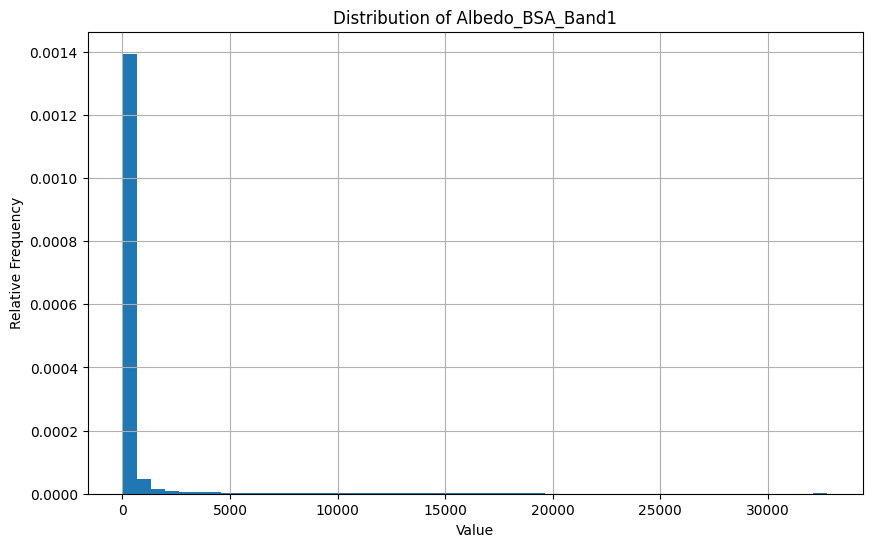

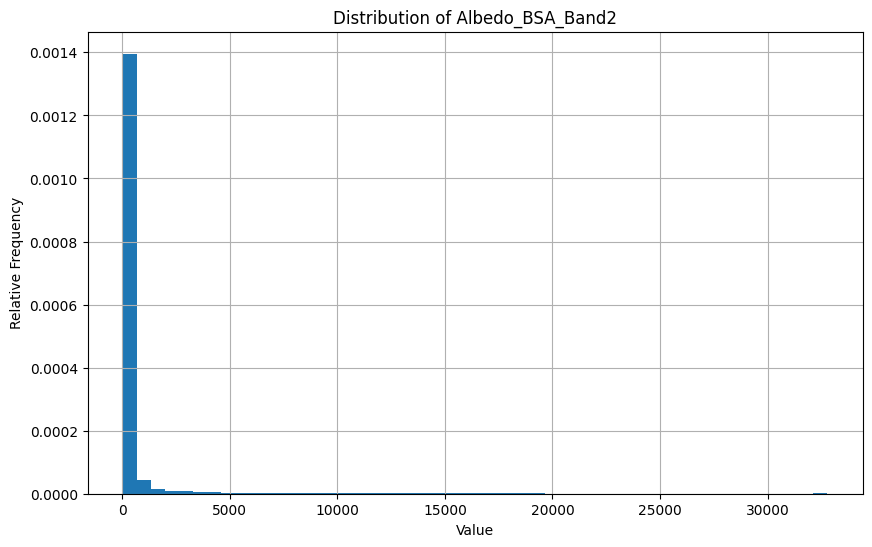

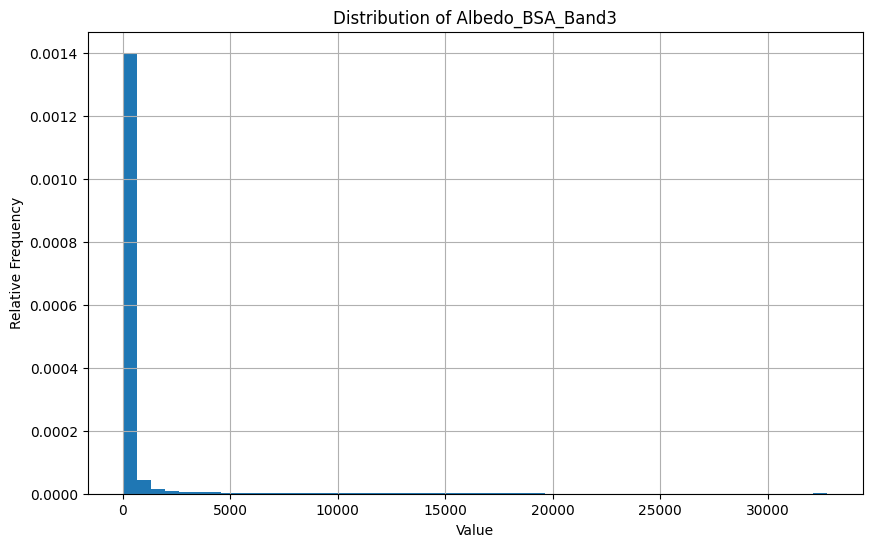

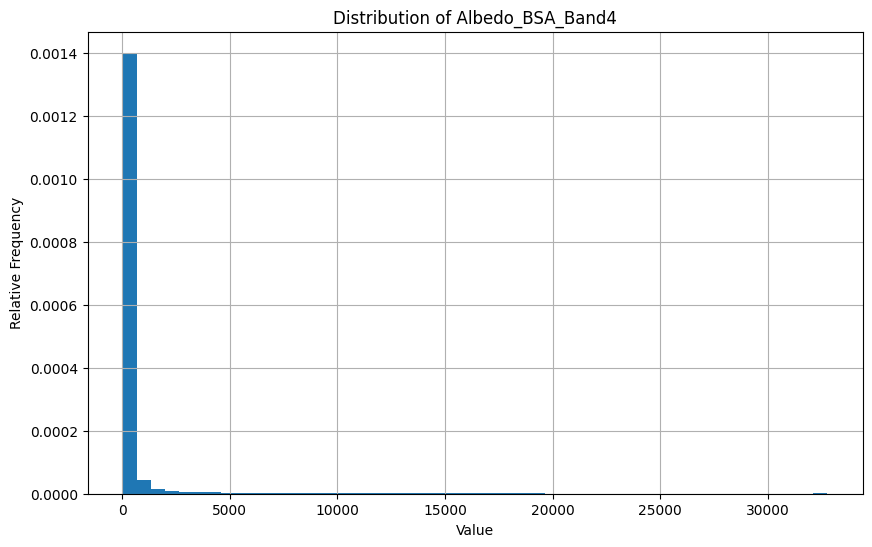

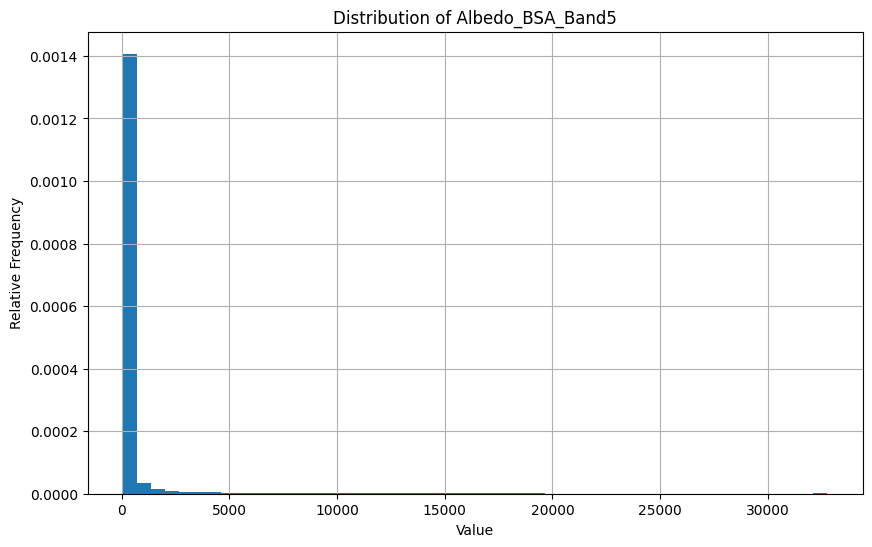

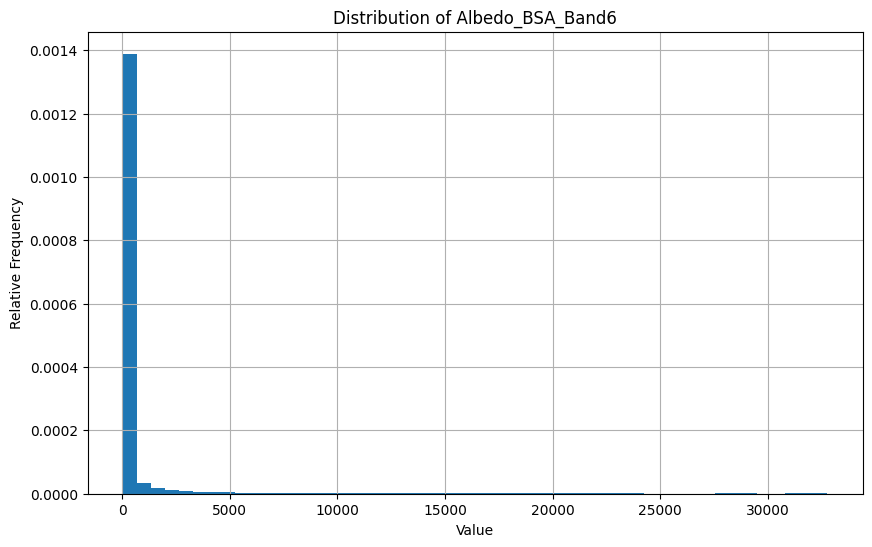

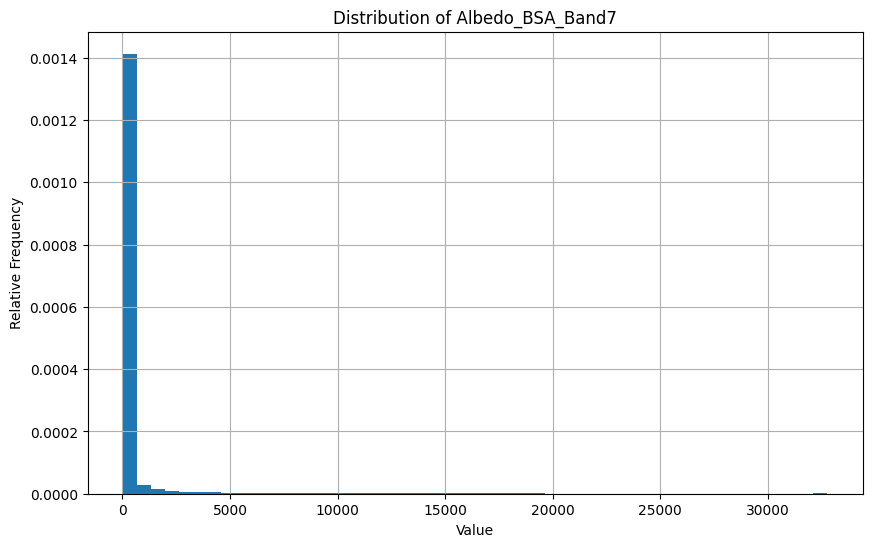

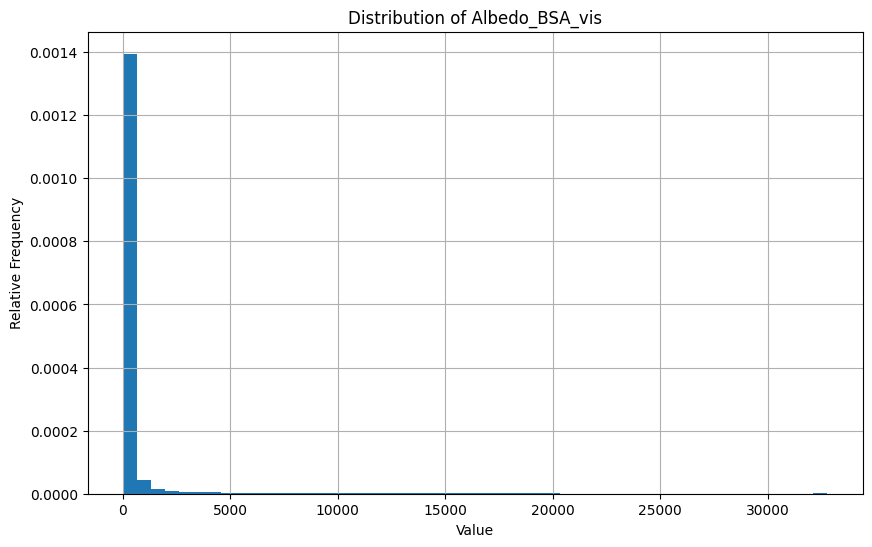

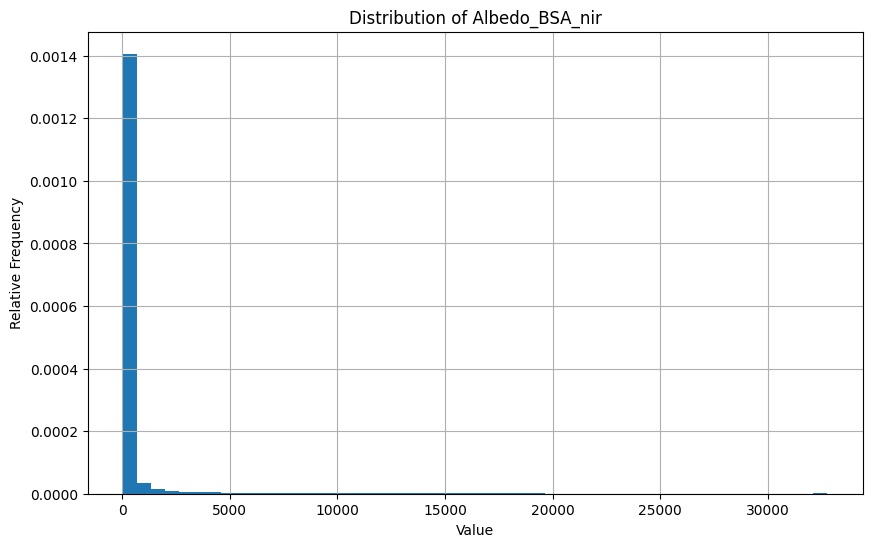

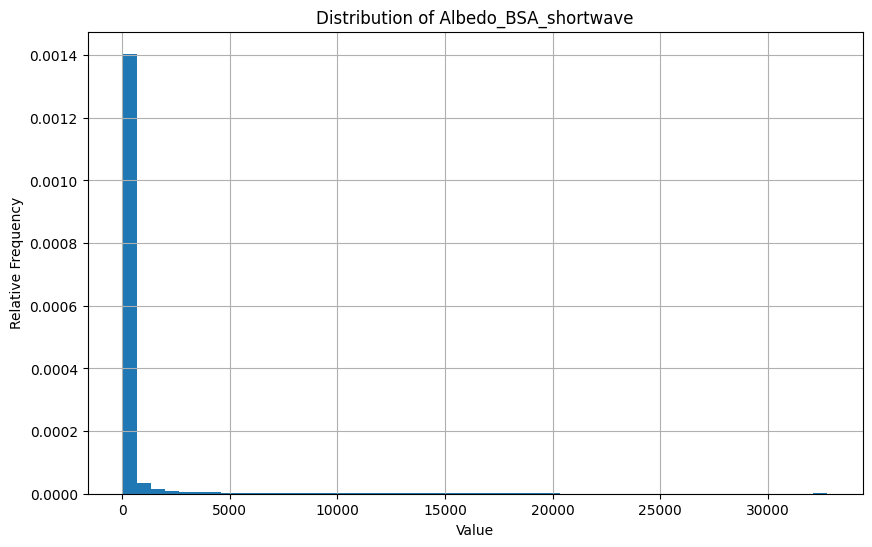

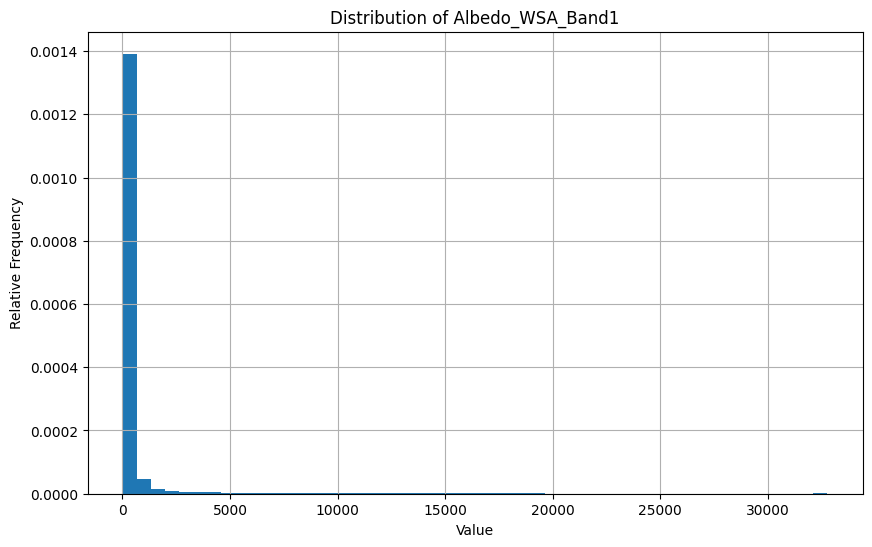

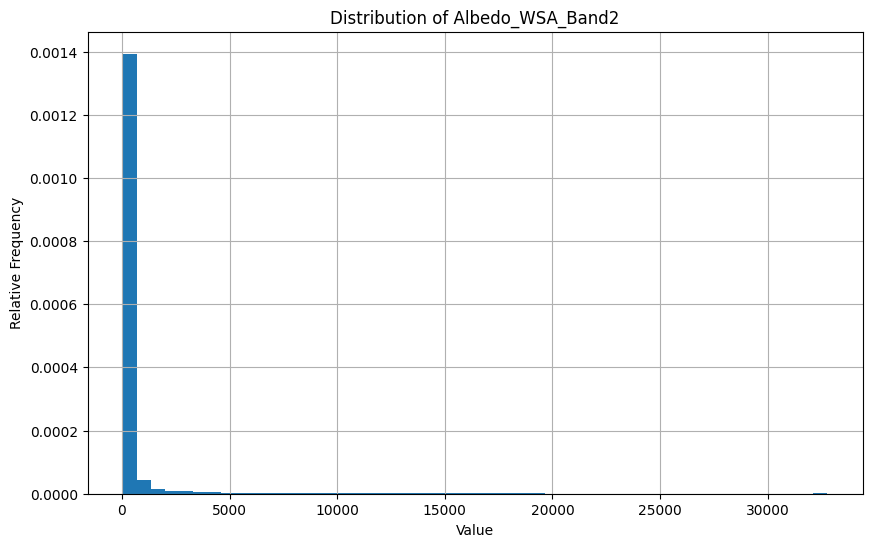

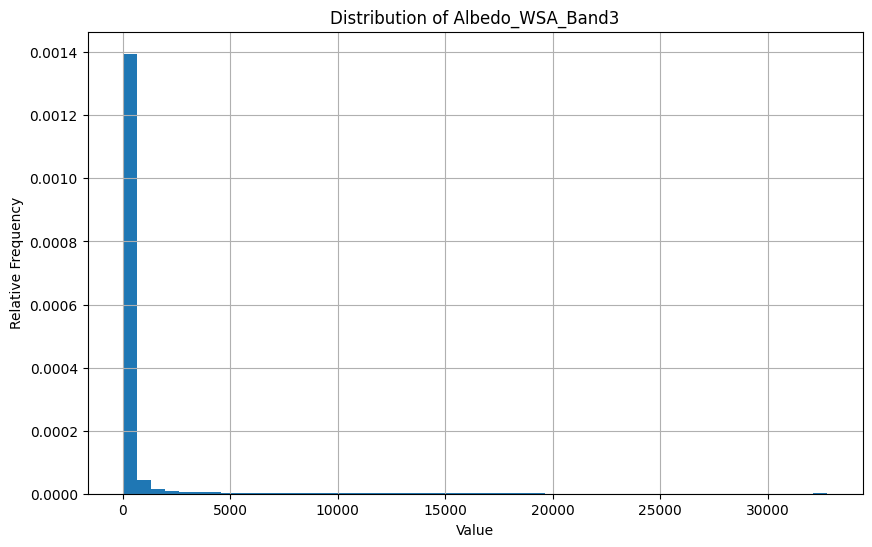

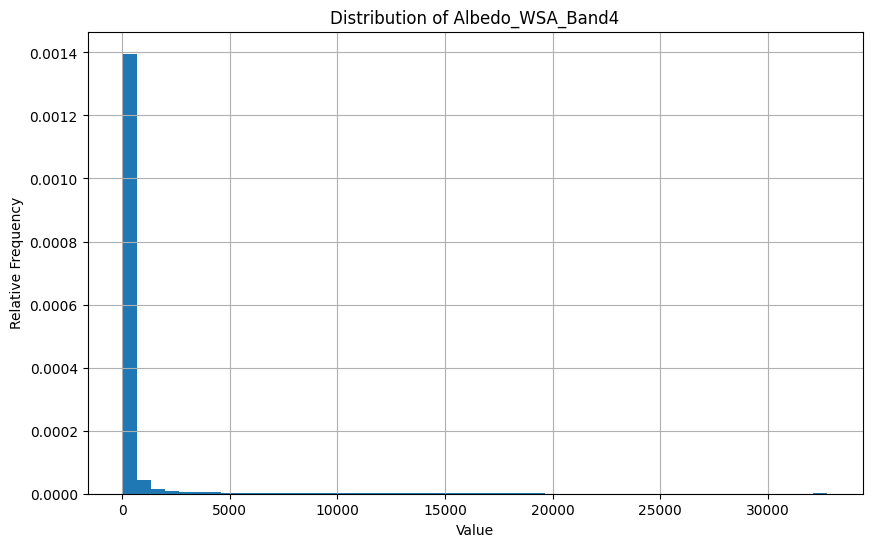

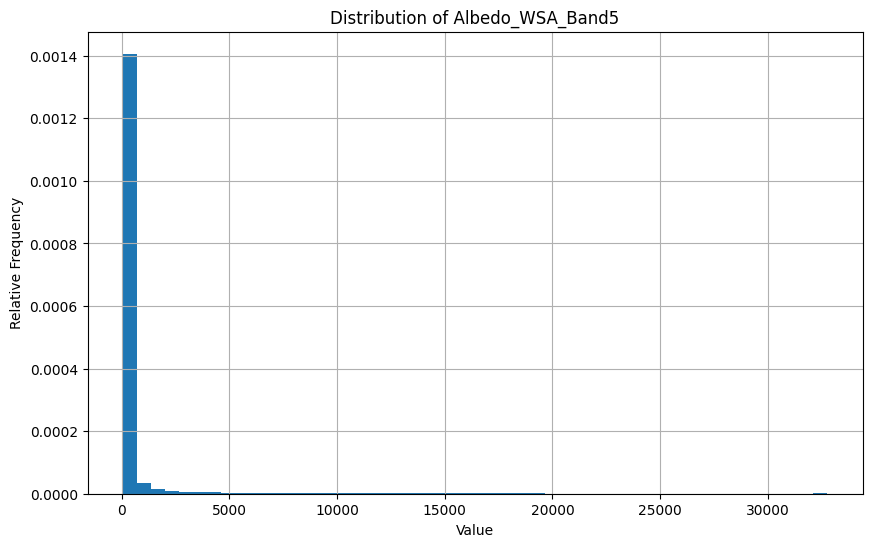

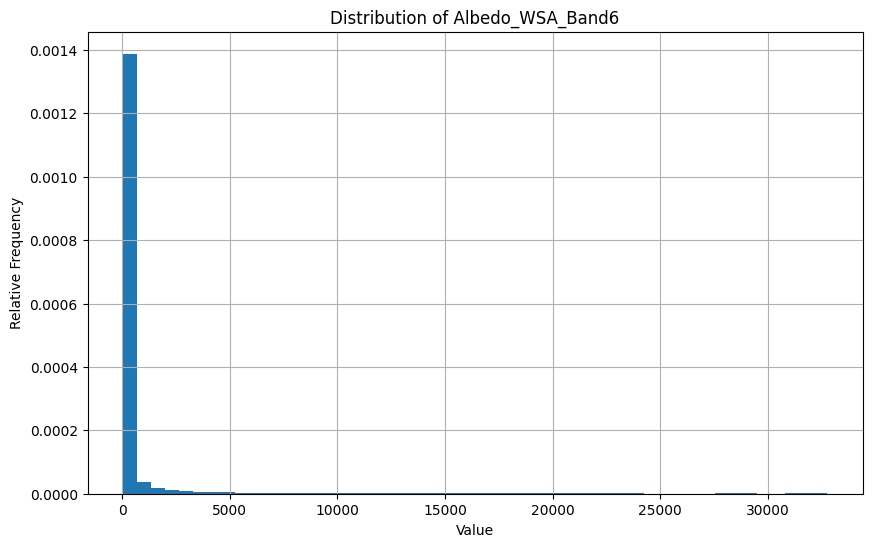

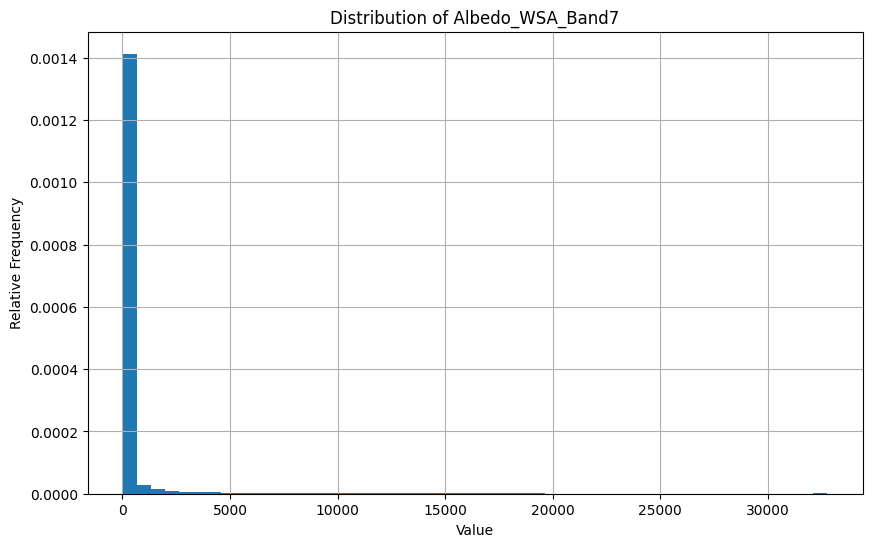

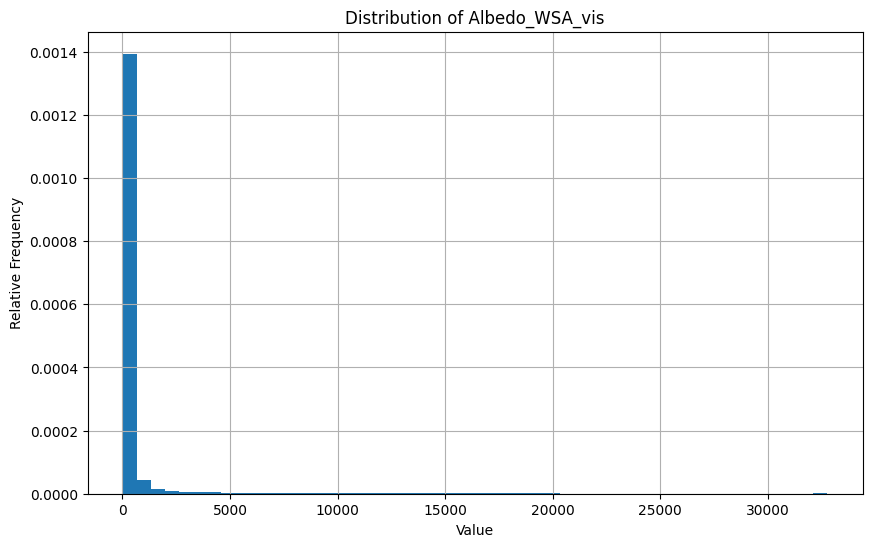

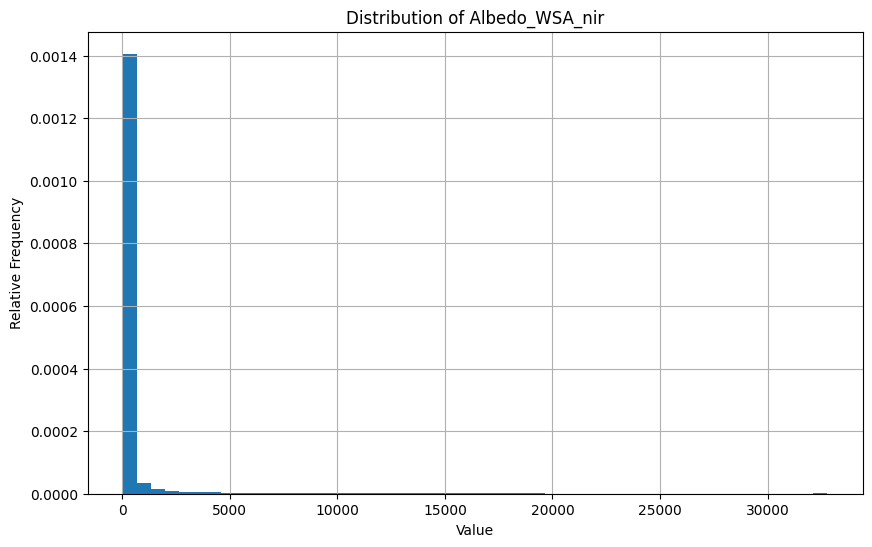

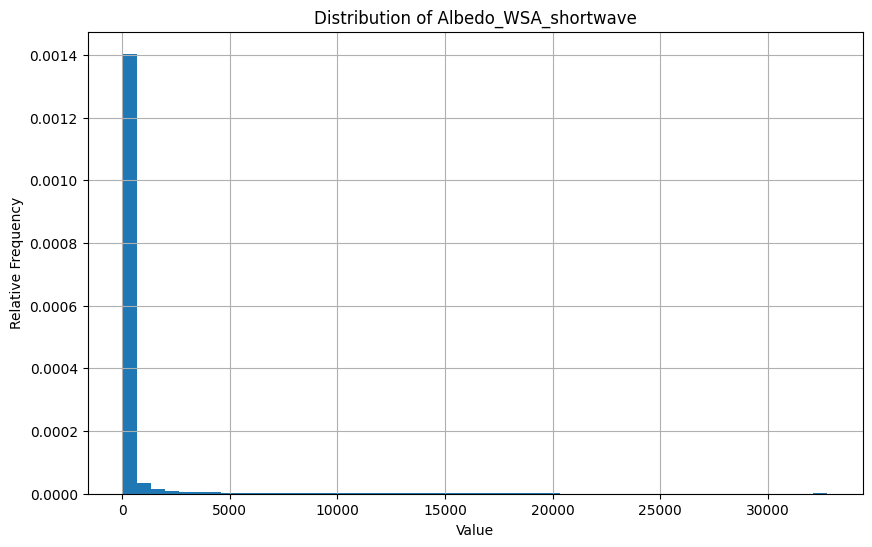

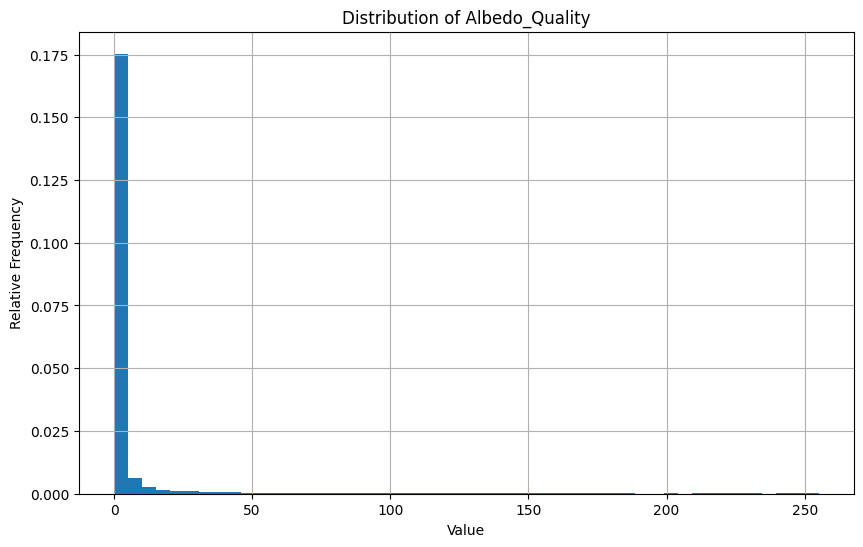

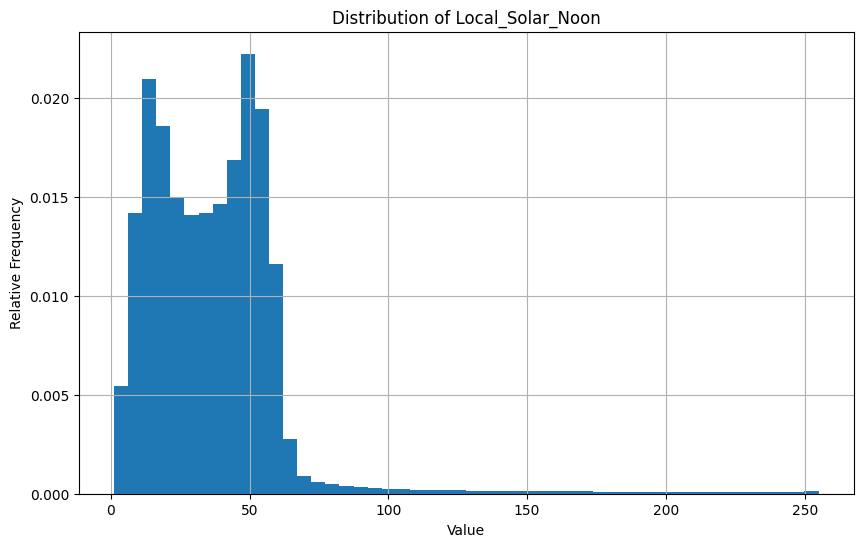

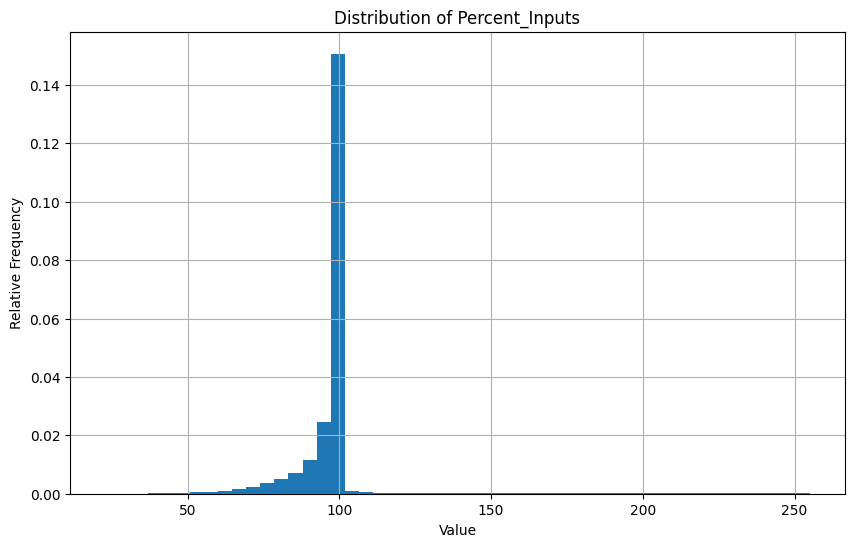

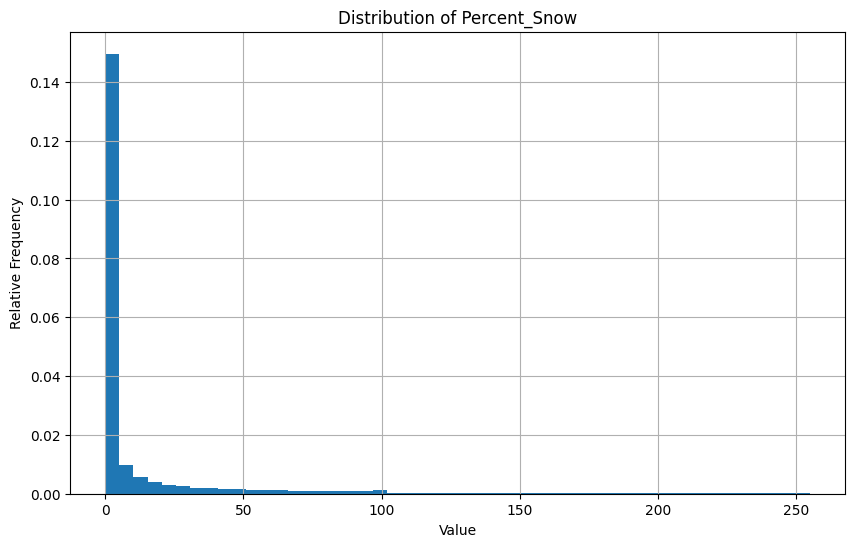

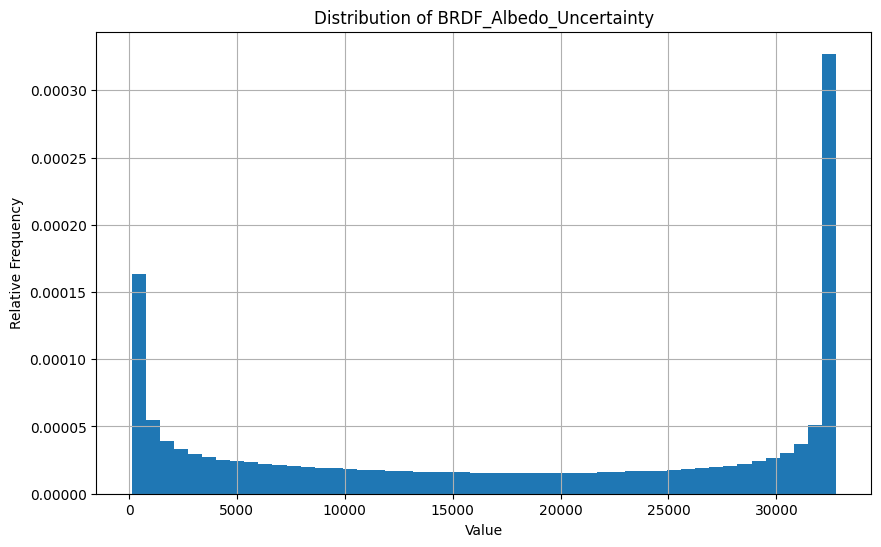

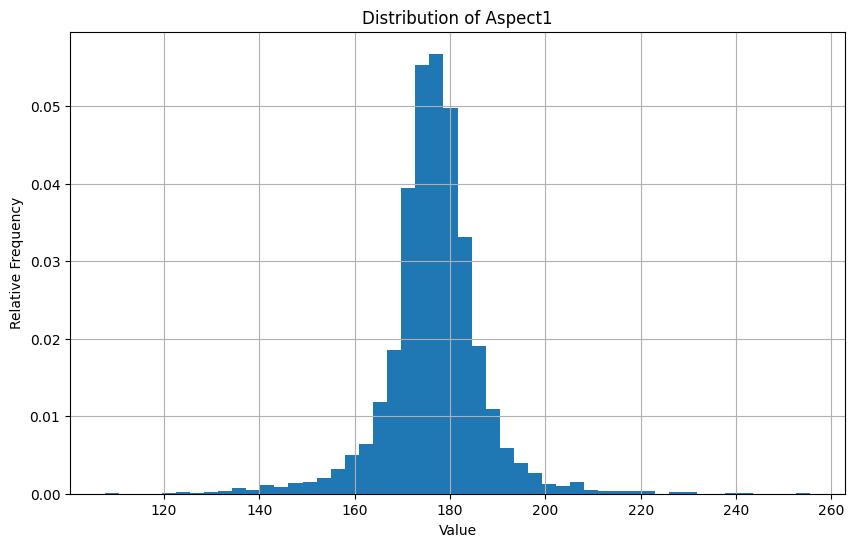

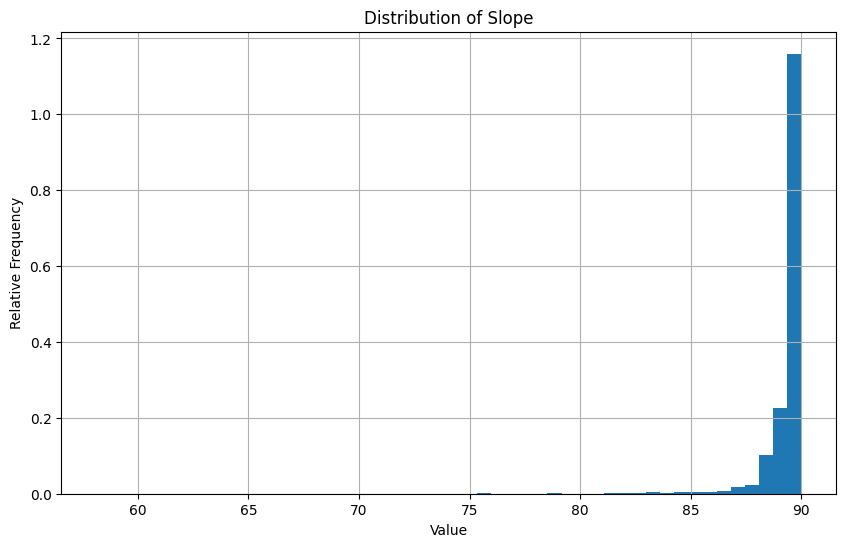

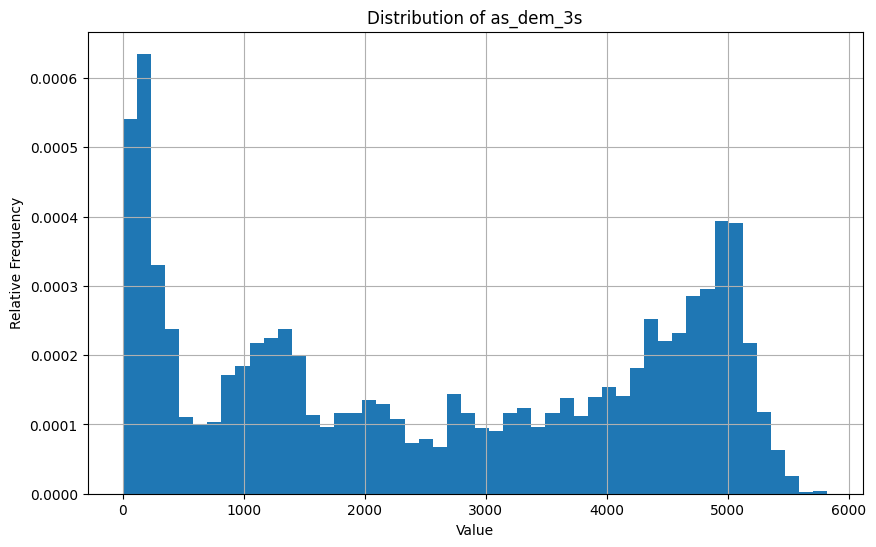

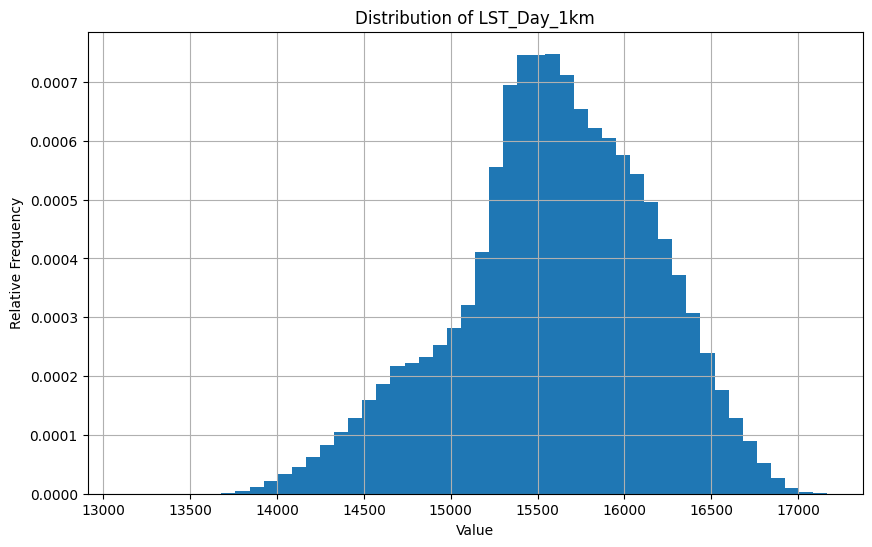

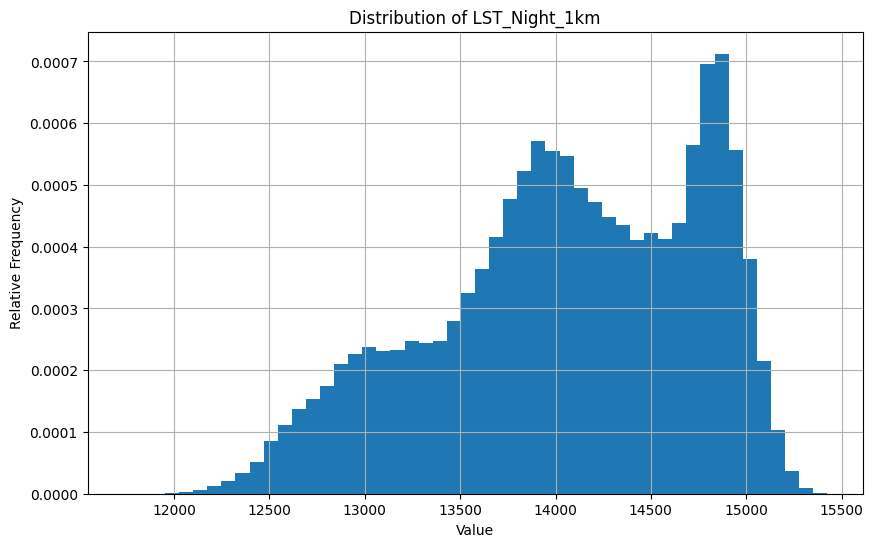

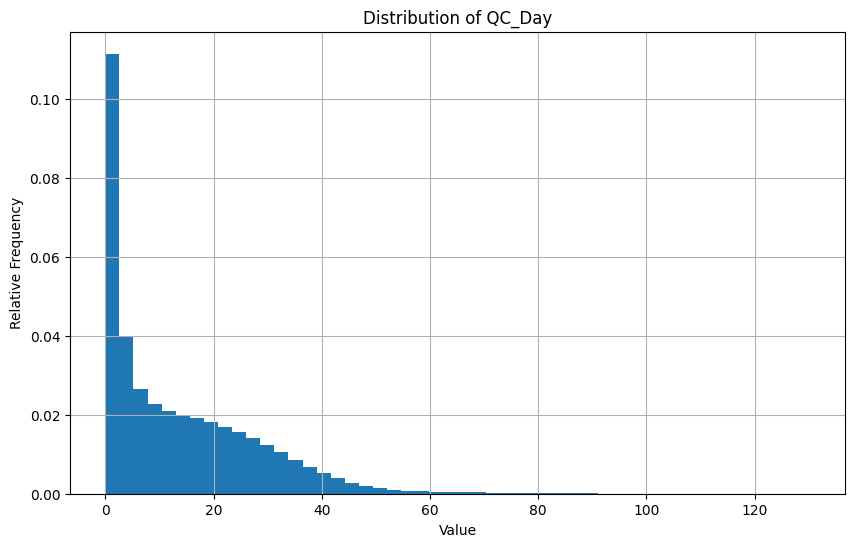

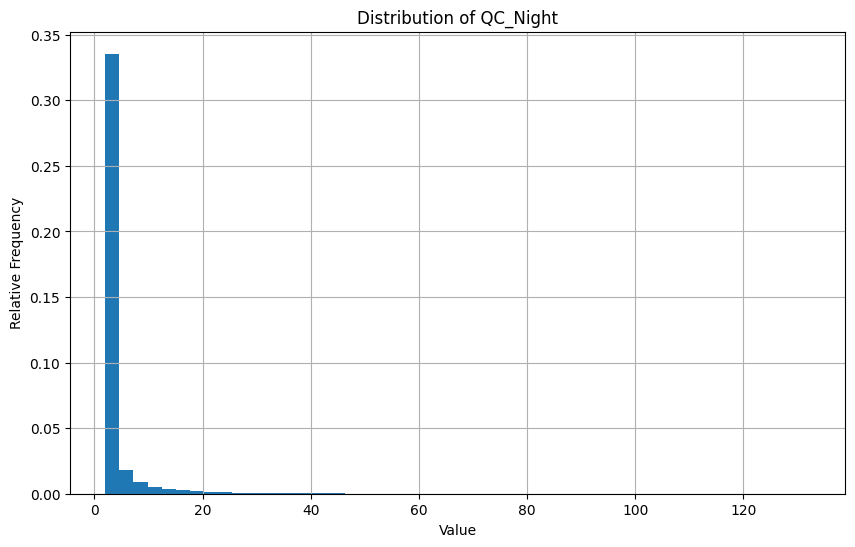

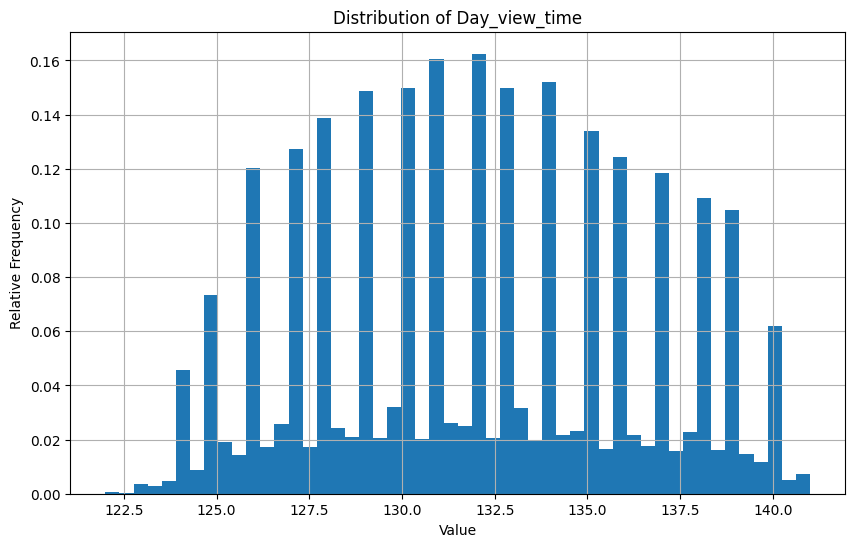

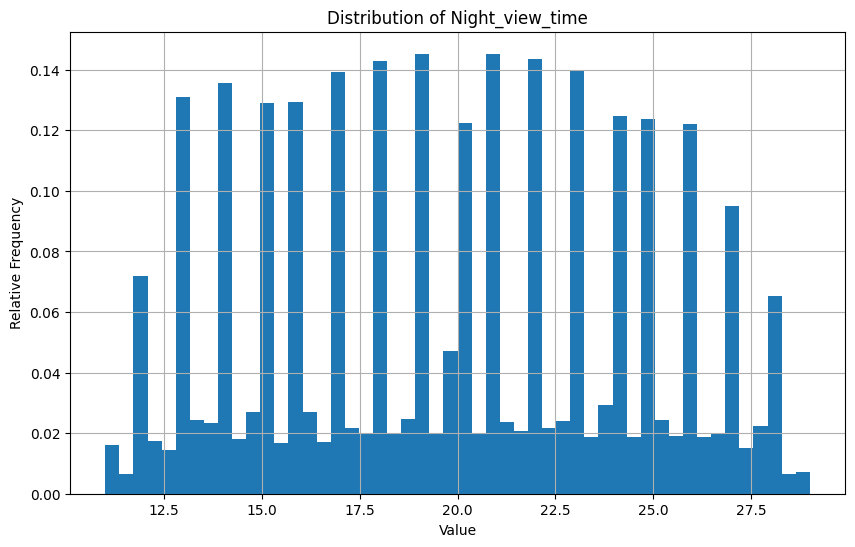

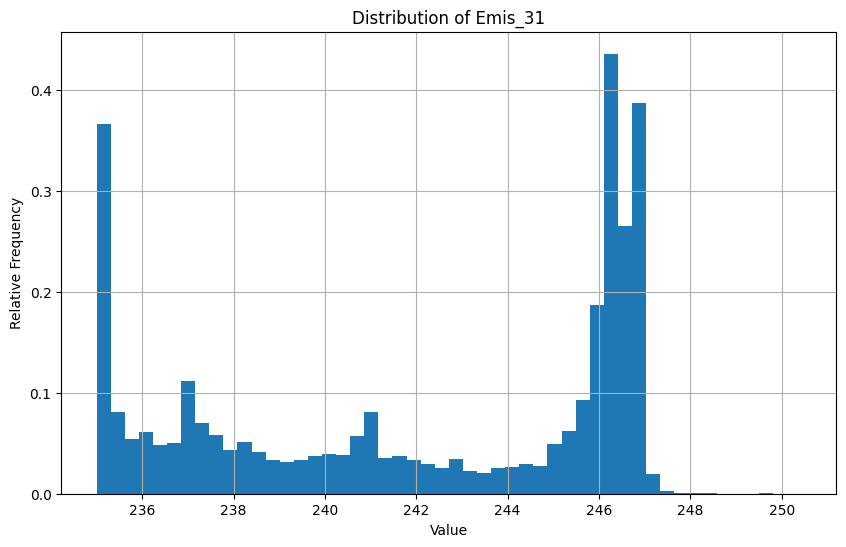

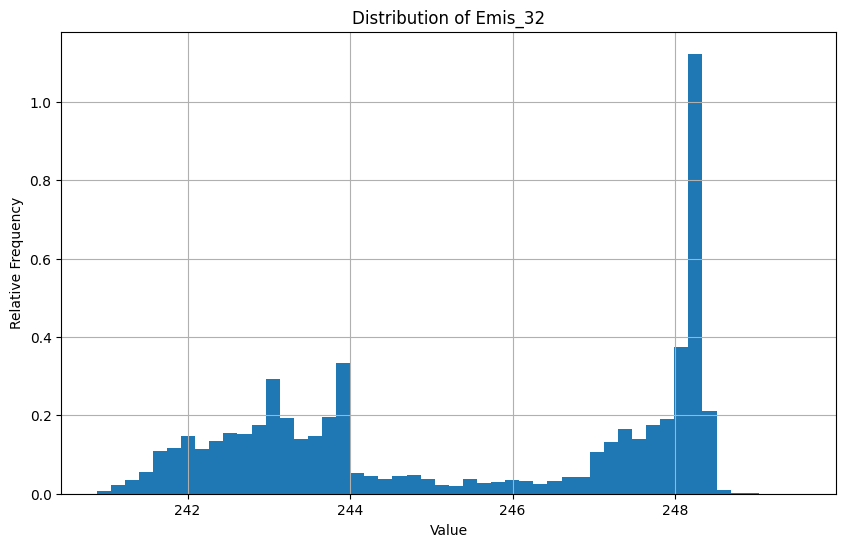

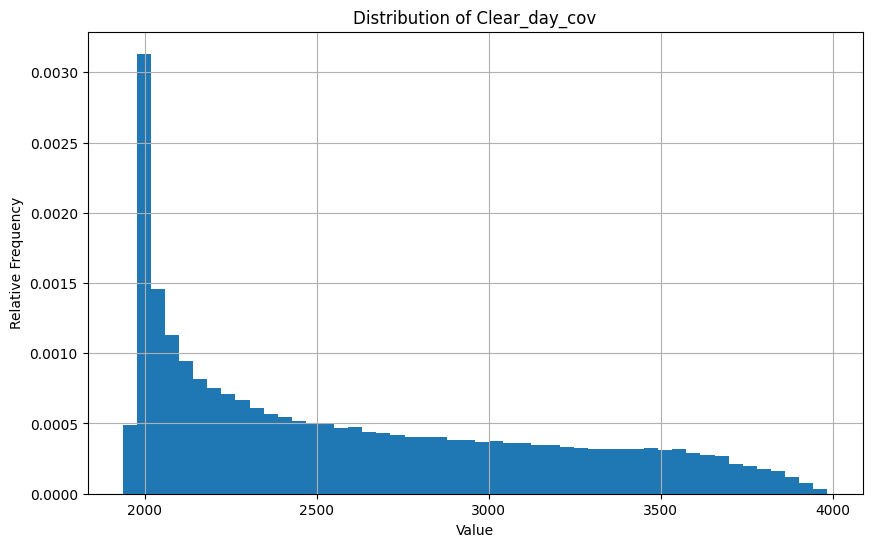

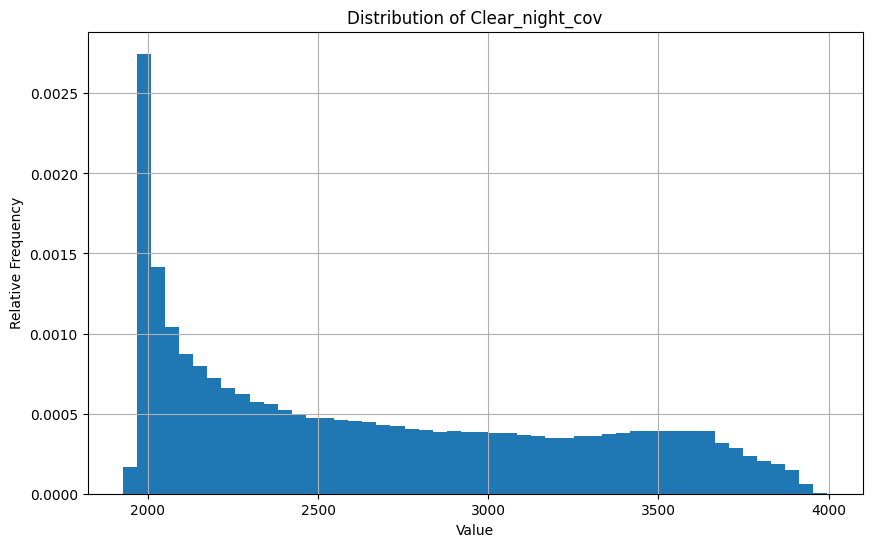

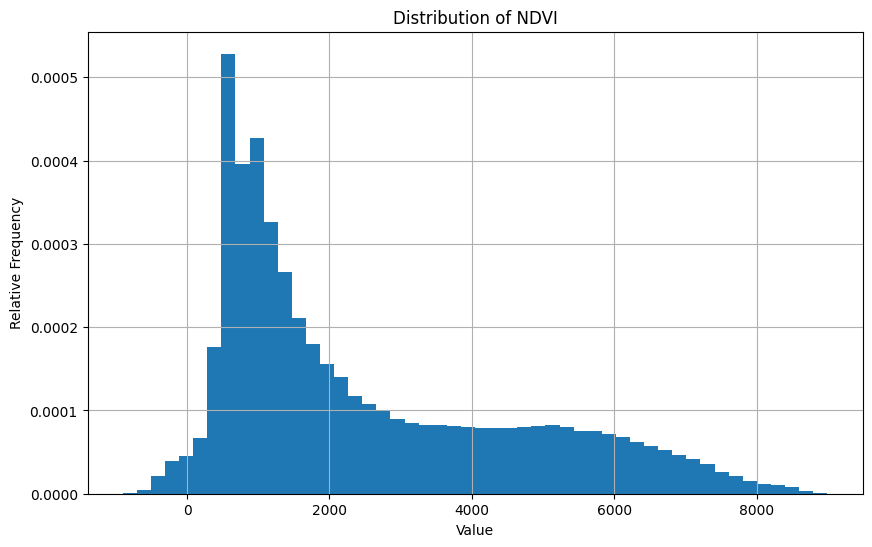

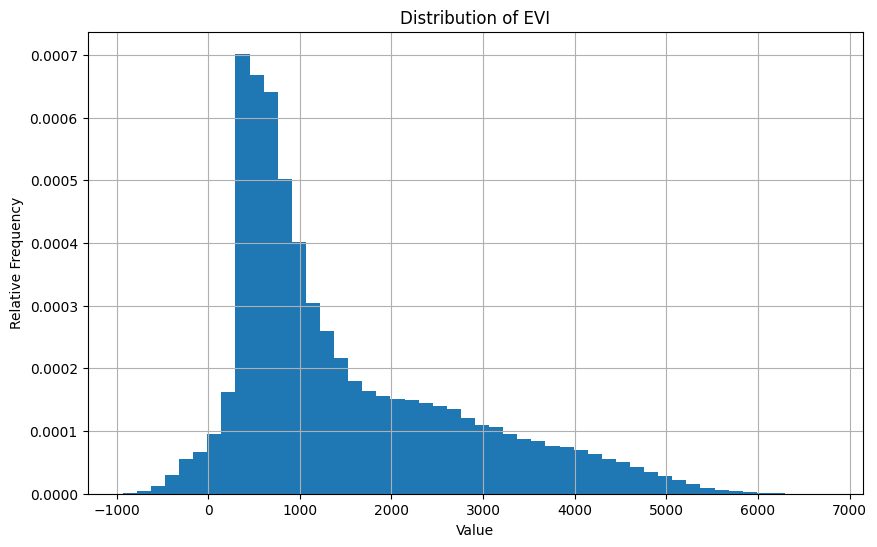

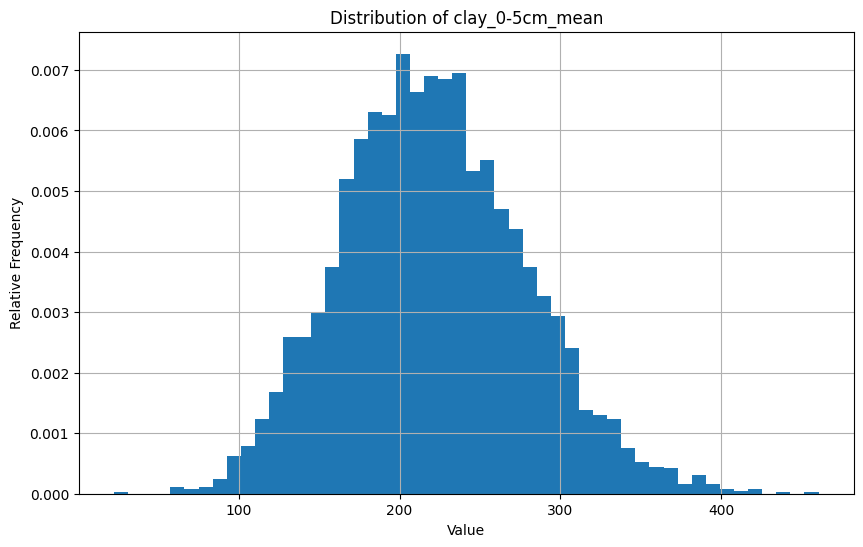

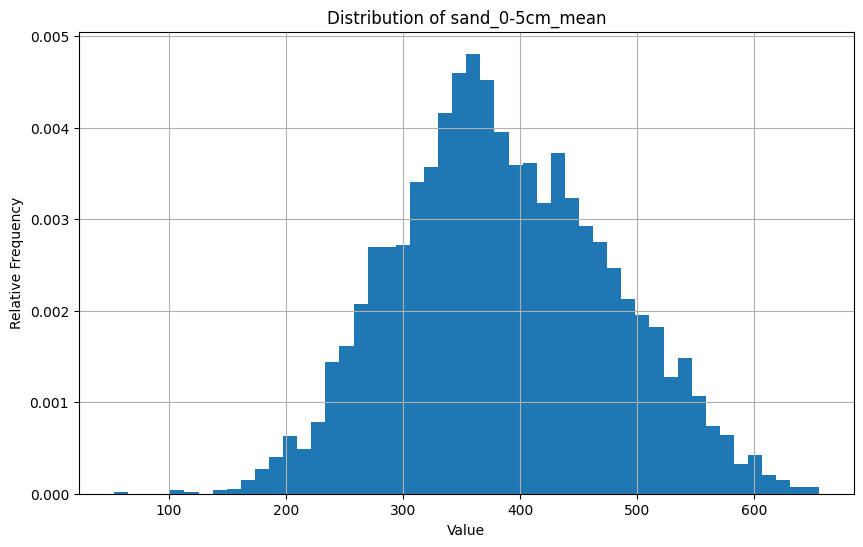

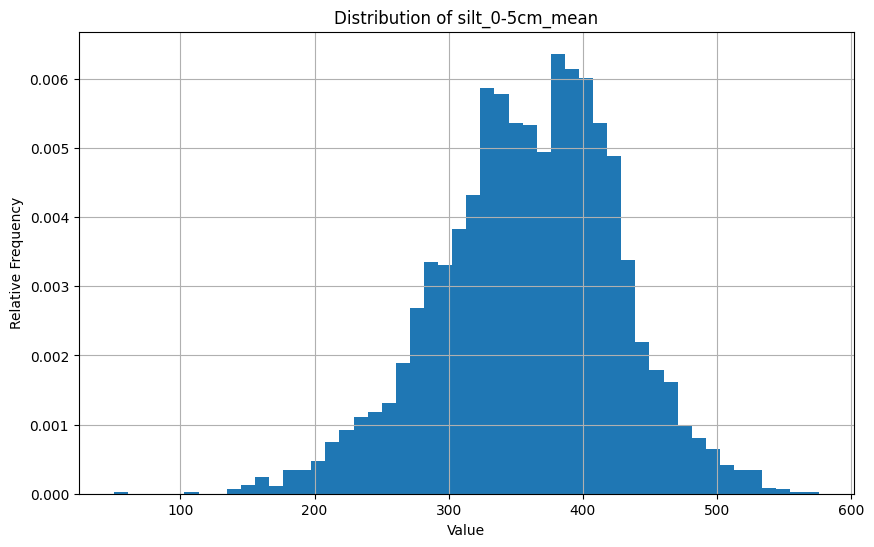

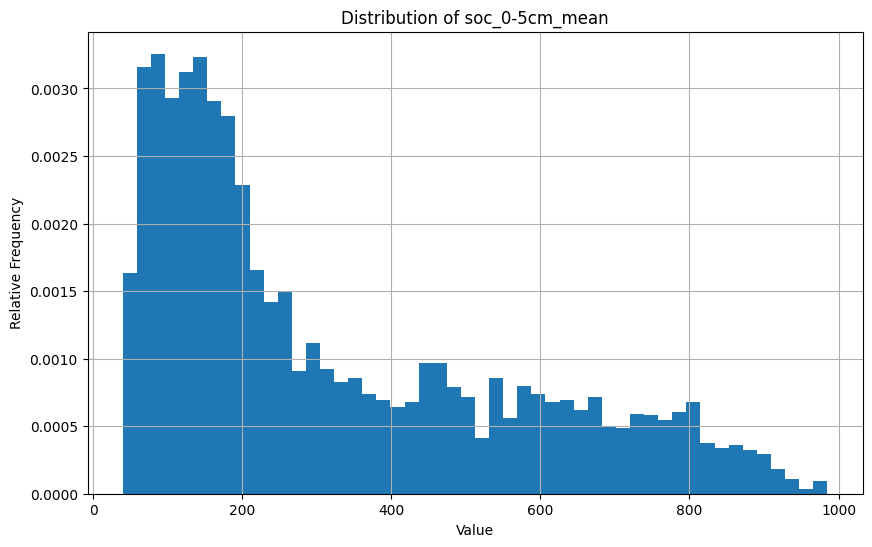

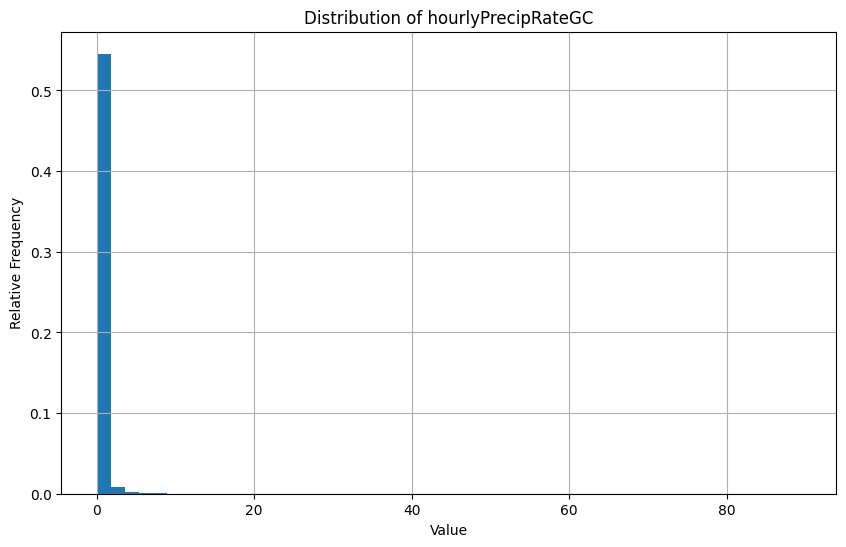

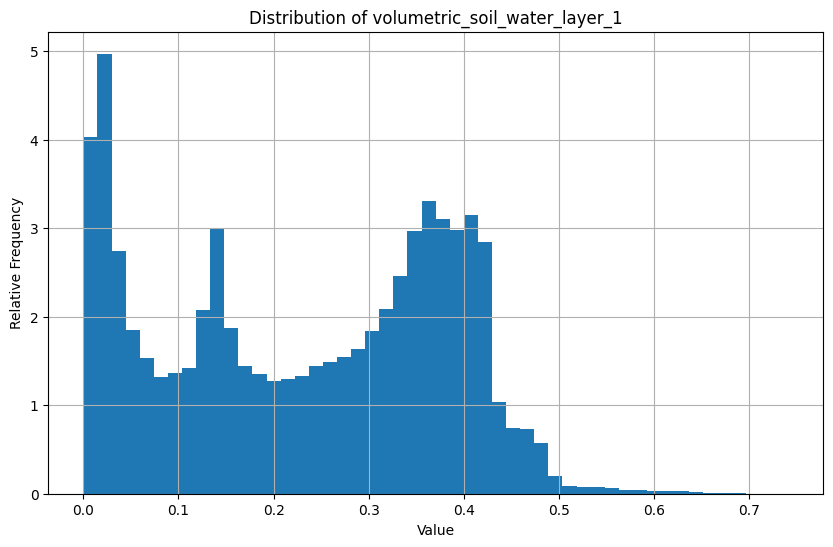

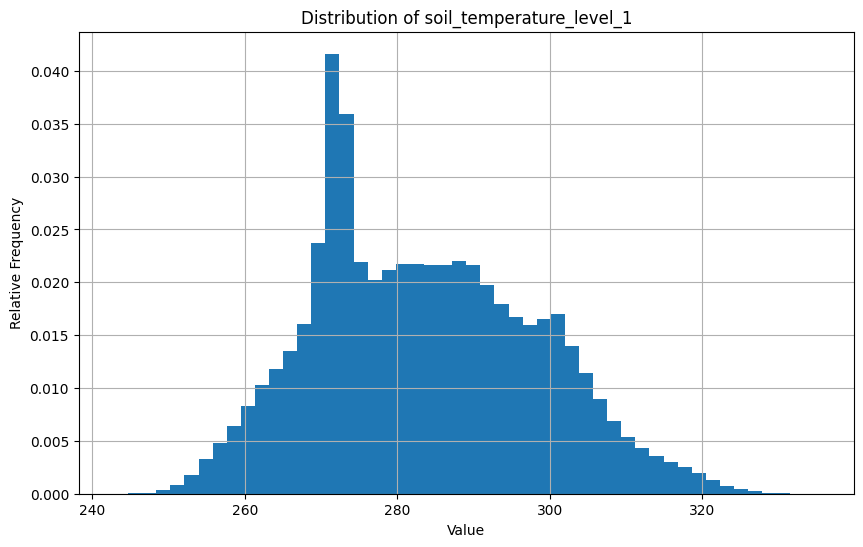

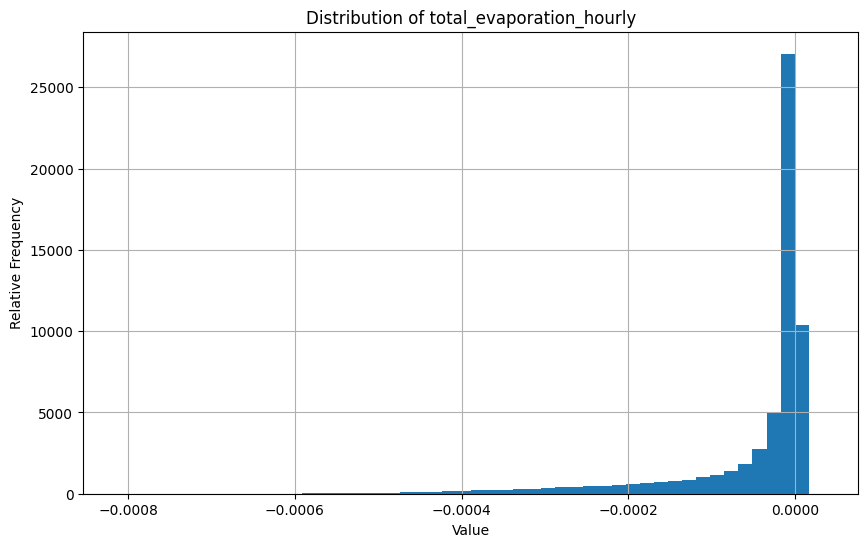

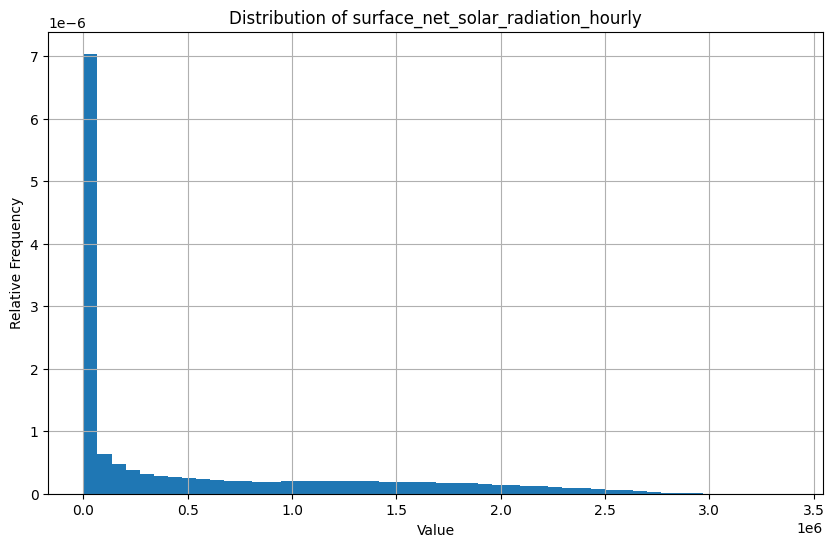

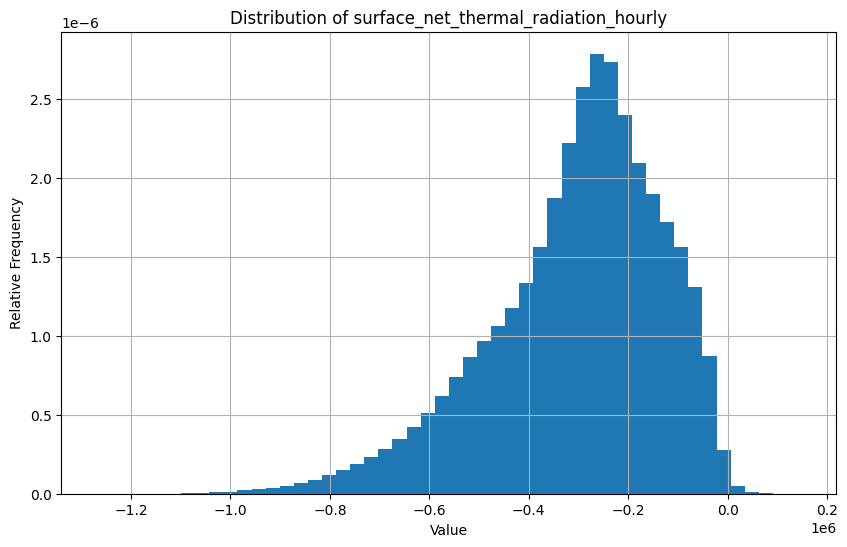

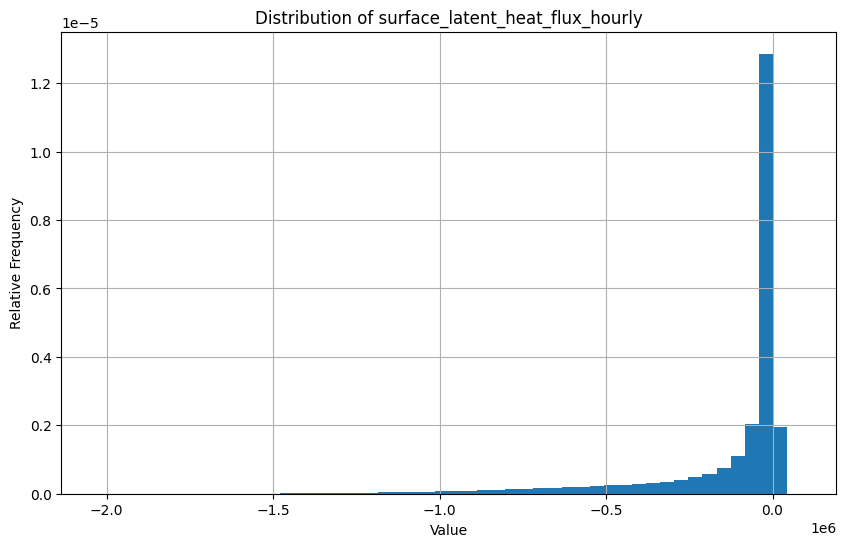

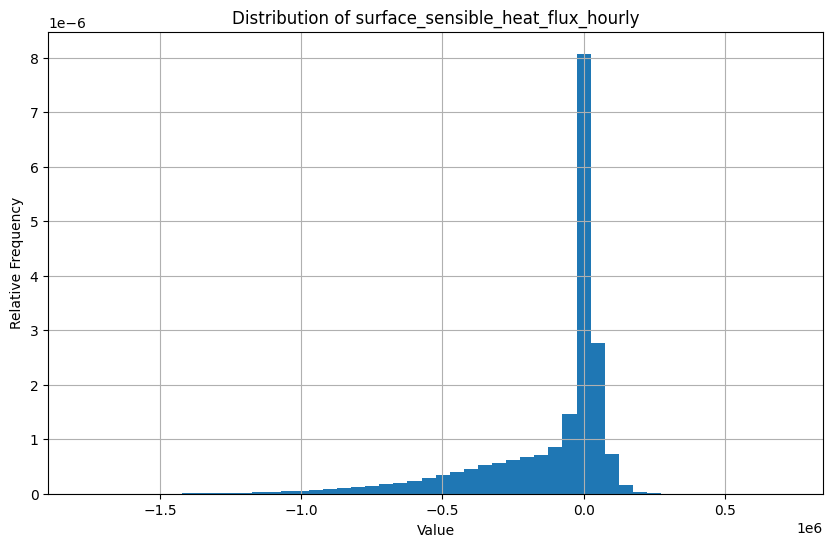

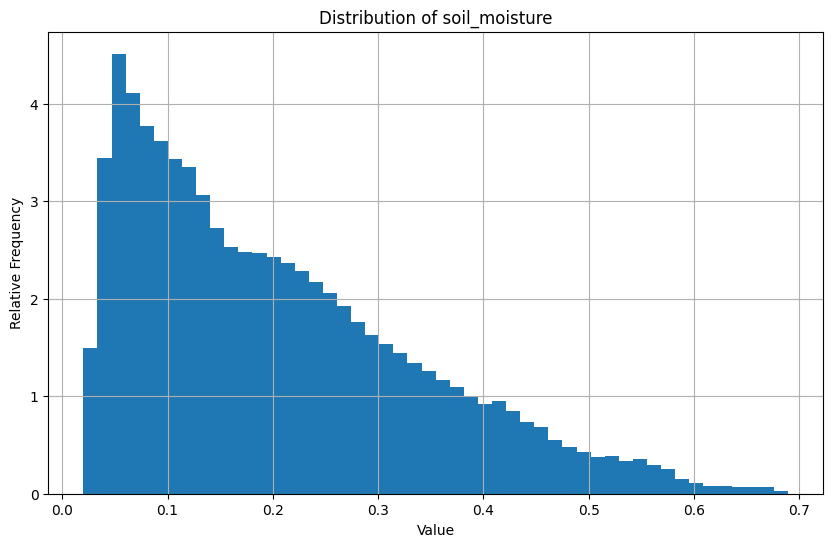

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# 打开.nc文件
file_path = 'D:/Data_Store/Dataset/Original_Data/0.37_Data.nc'
file2_path = 'D:/Data_Store/Dataset/Original_Data/0.37_Data.nc'
data = xr.open_dataset(file_path)

# 循环每个变量并绘制直方图
for variable_name in data.data_vars:
    variable_data = data[variable_name]

    # Flatten the data for analysis
    flattened_data = variable_data.values.flatten()

    # Remove NaN values for plotting
    clean_data = flattened_data[~np.isnan(flattened_data)]

    # Skip if the variable has no valid data points
    if clean_data.size == 0:
        print(f"No valid data for variable '{variable_name}', skipping.")
        continue

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(clean_data, bins=50, density=True)  # Using density=True for relative frequency
    plt.title(f'Distribution of {variable_name}')
    plt.xlabel('Value')
    plt.ylabel('Relative Frequency')
    plt.grid(True)
    plt.show()


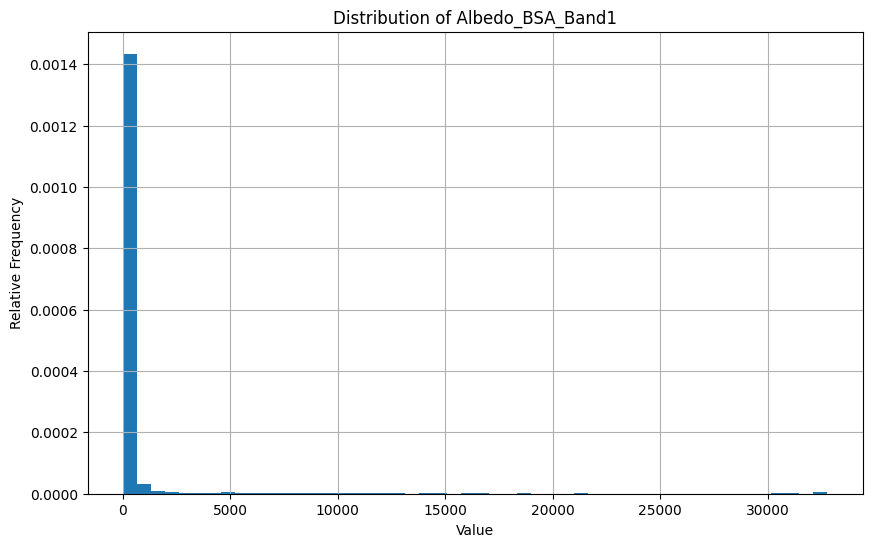

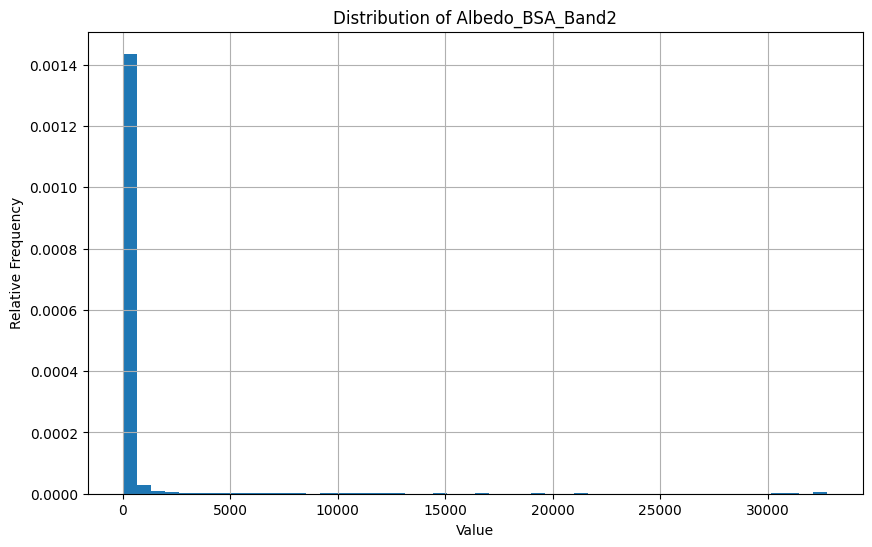

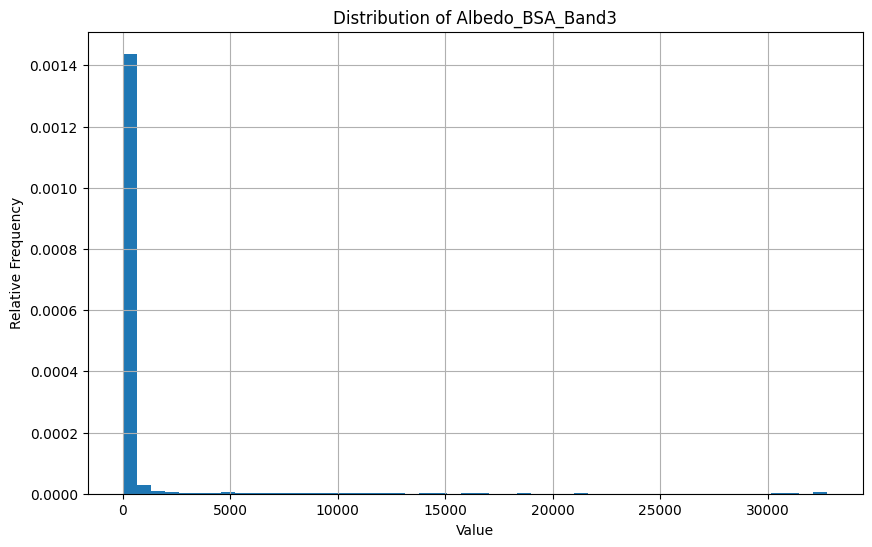

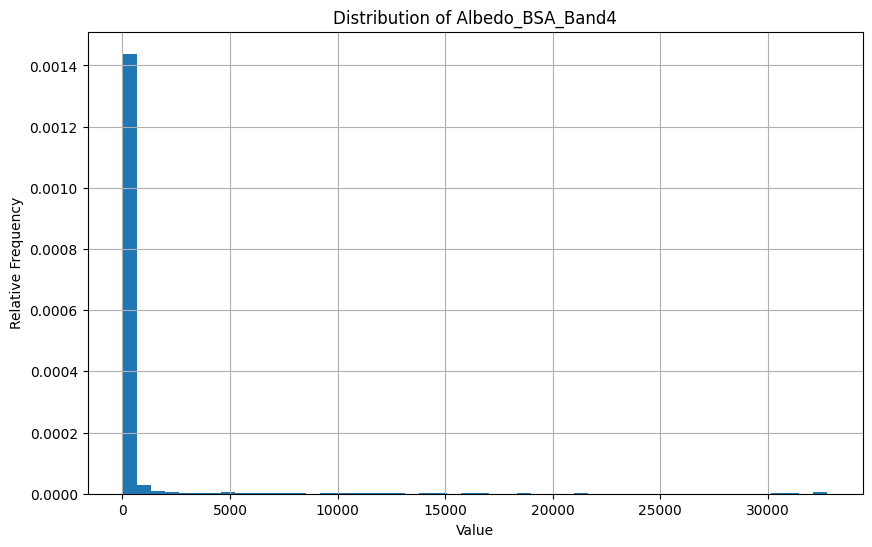

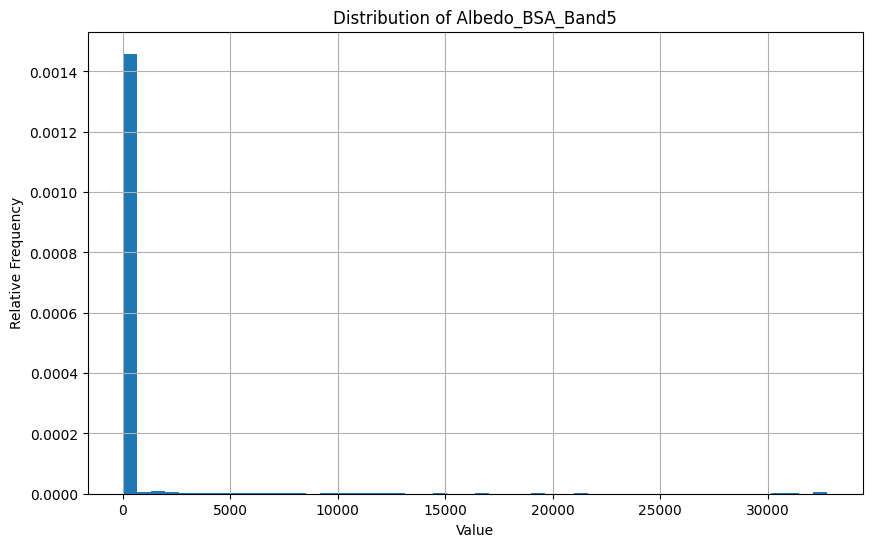

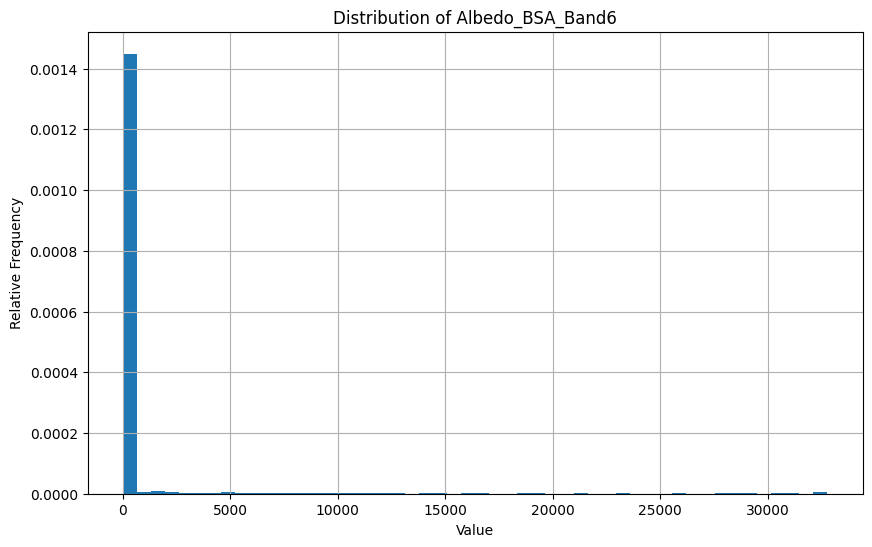

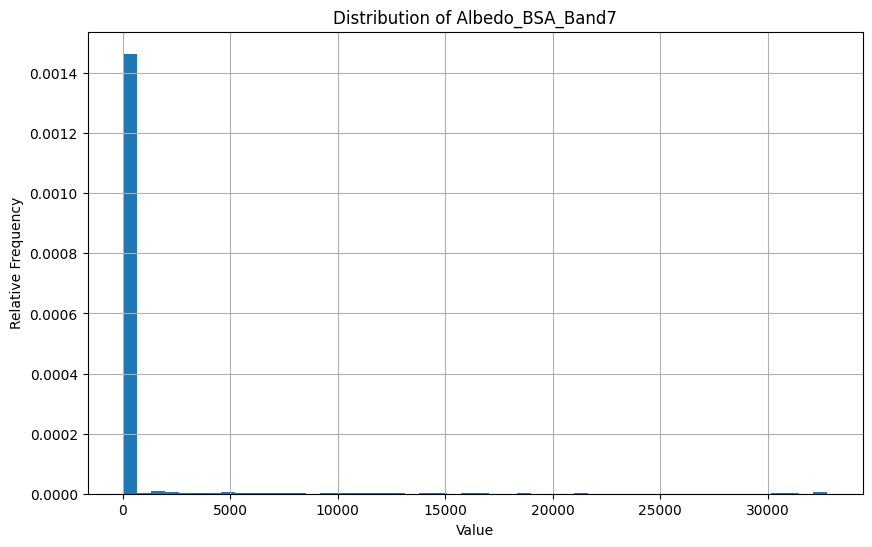

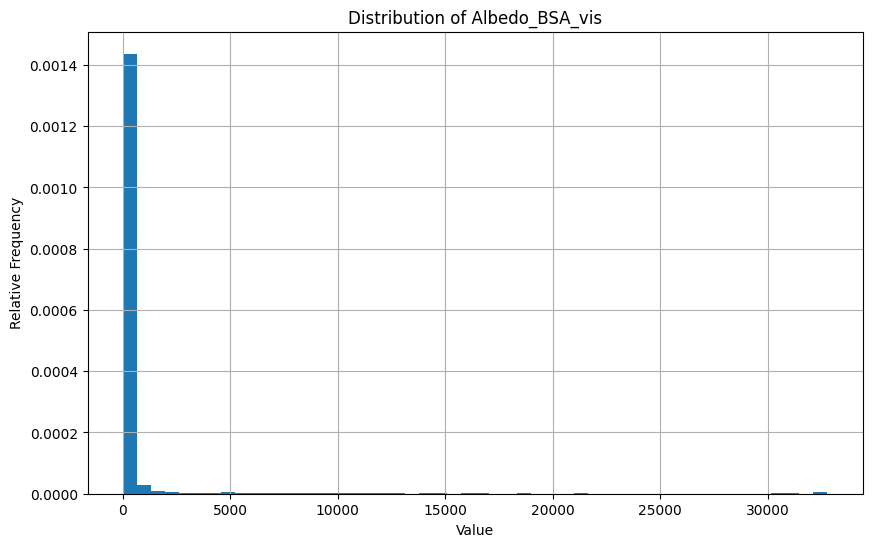

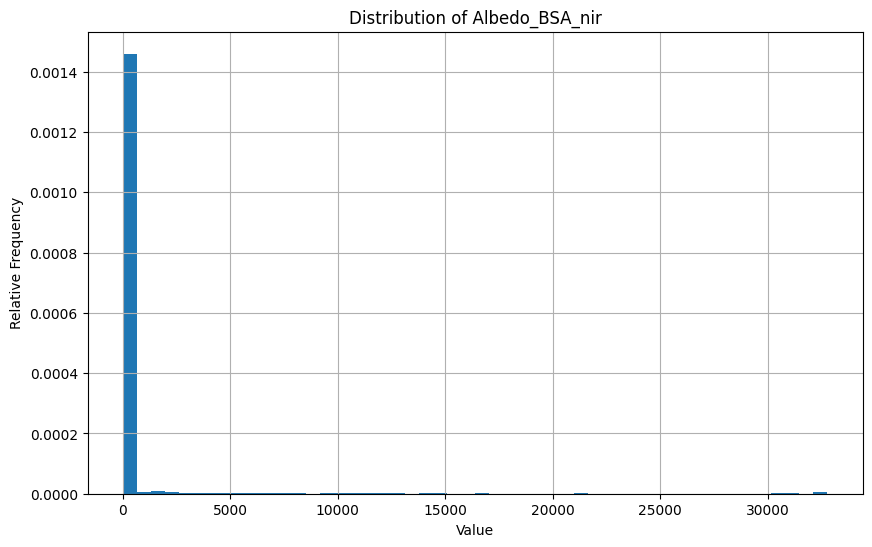

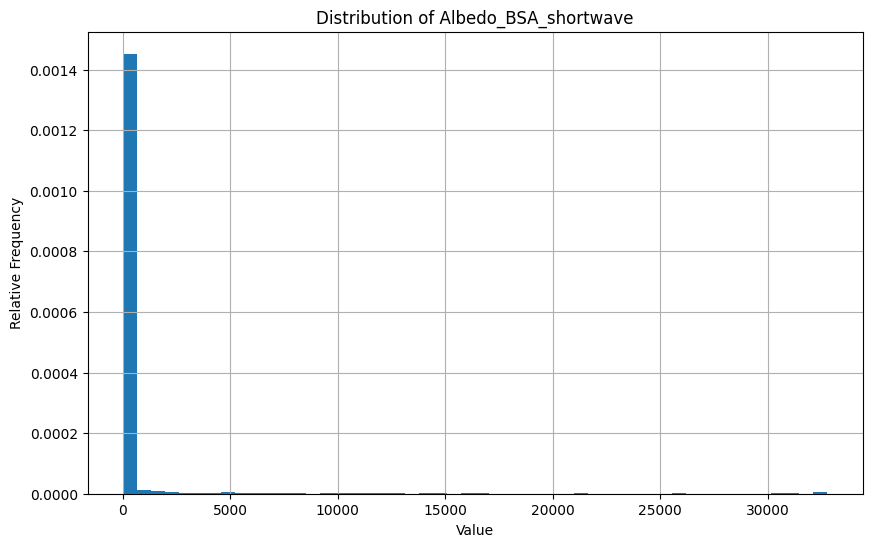

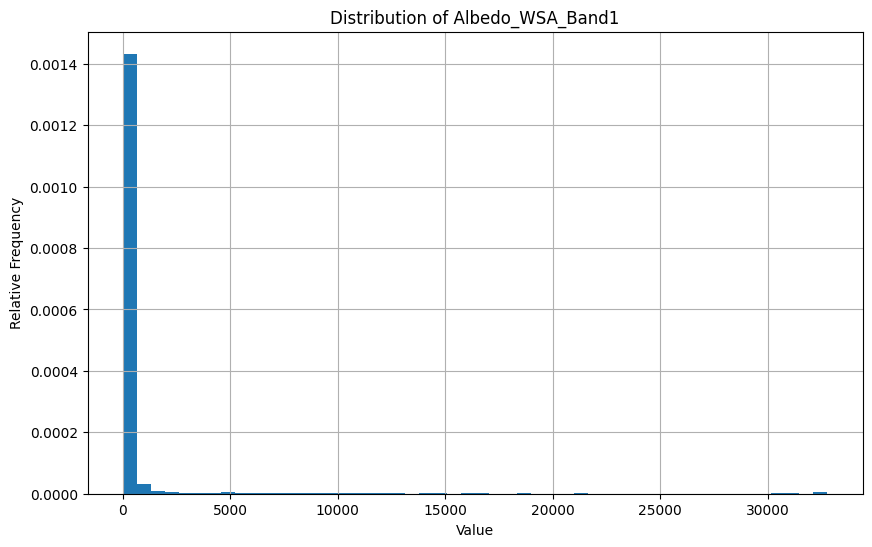

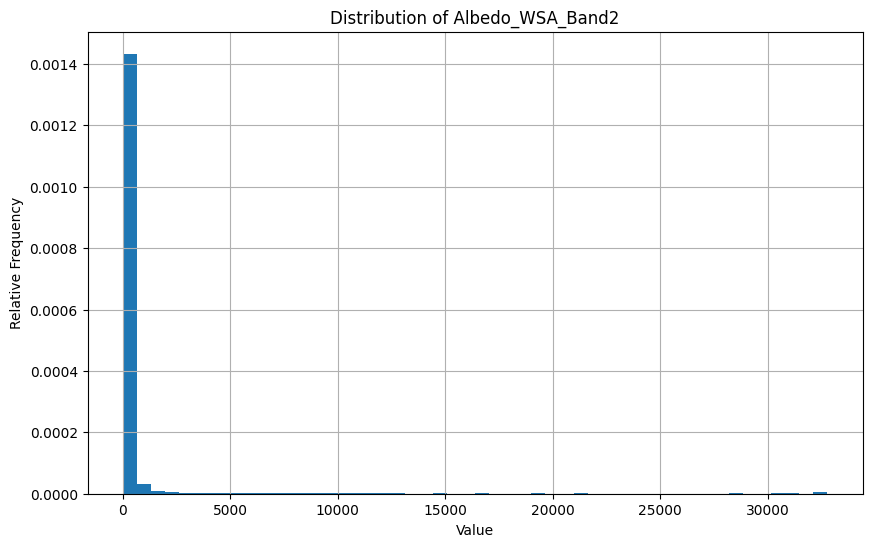

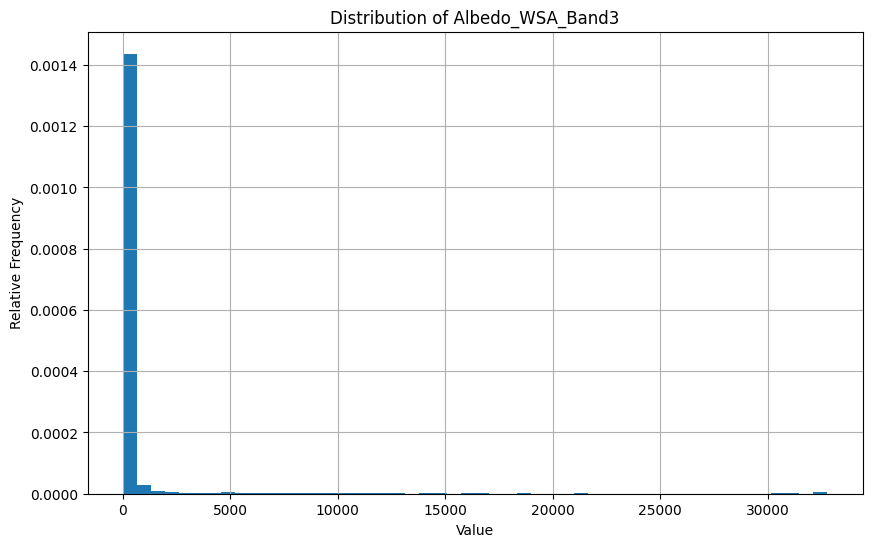

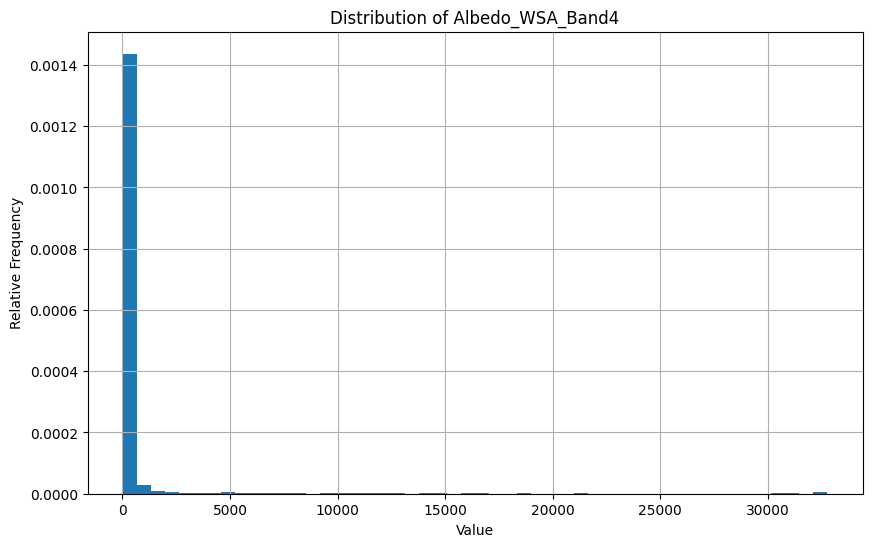

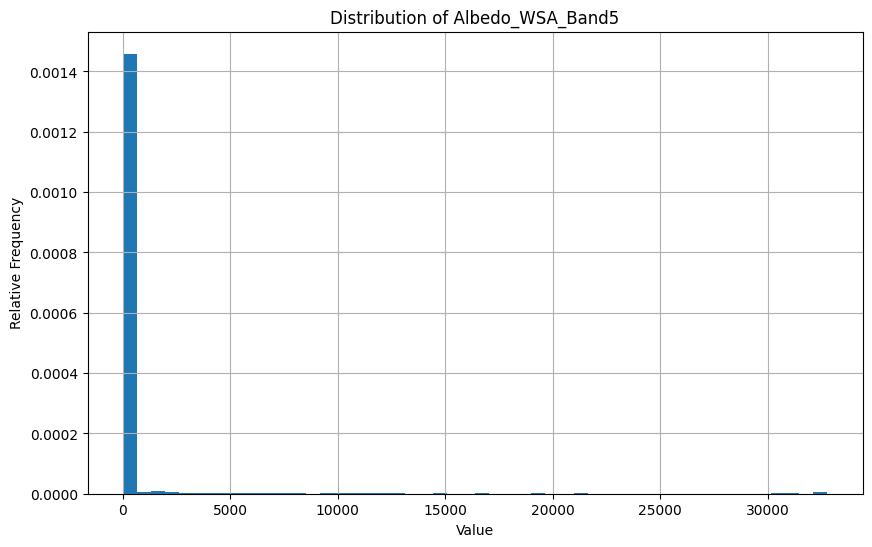

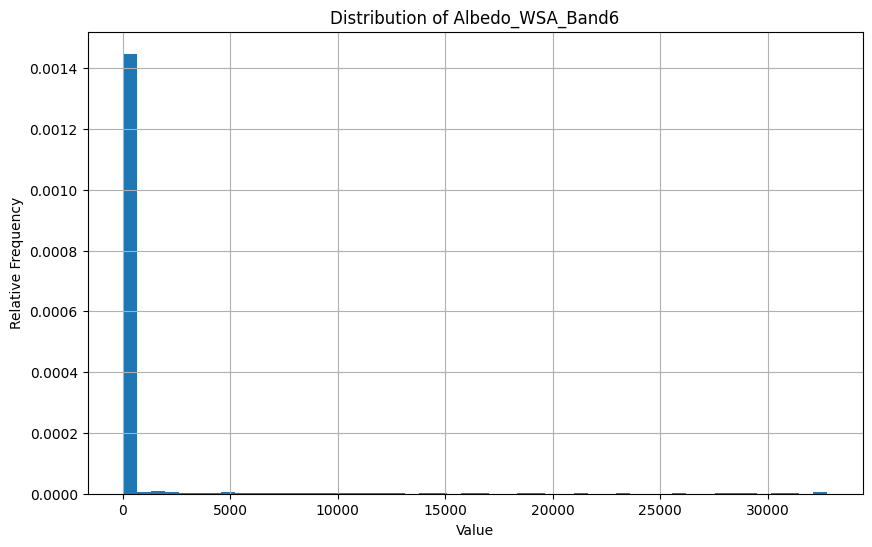

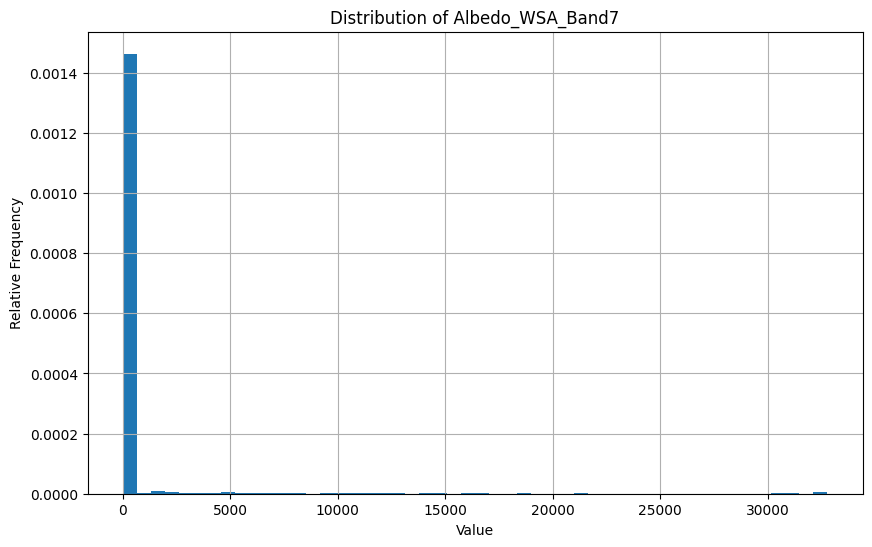

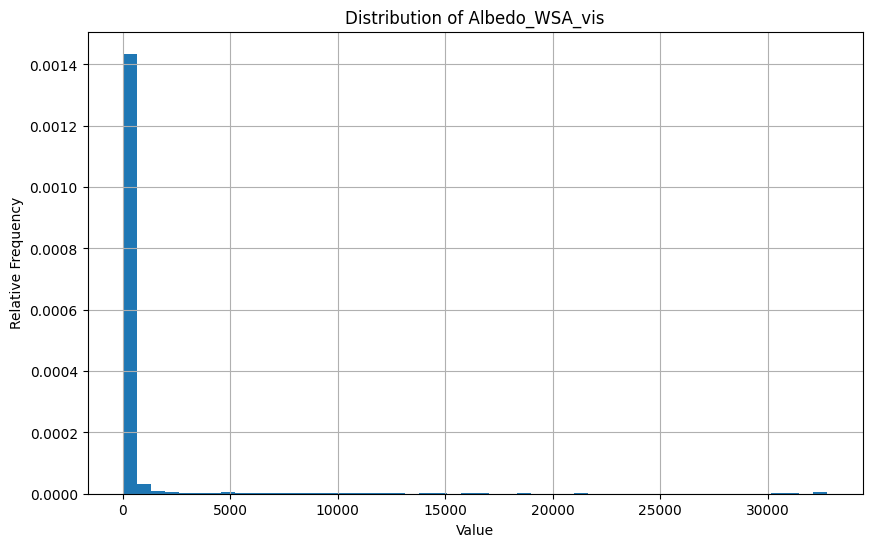

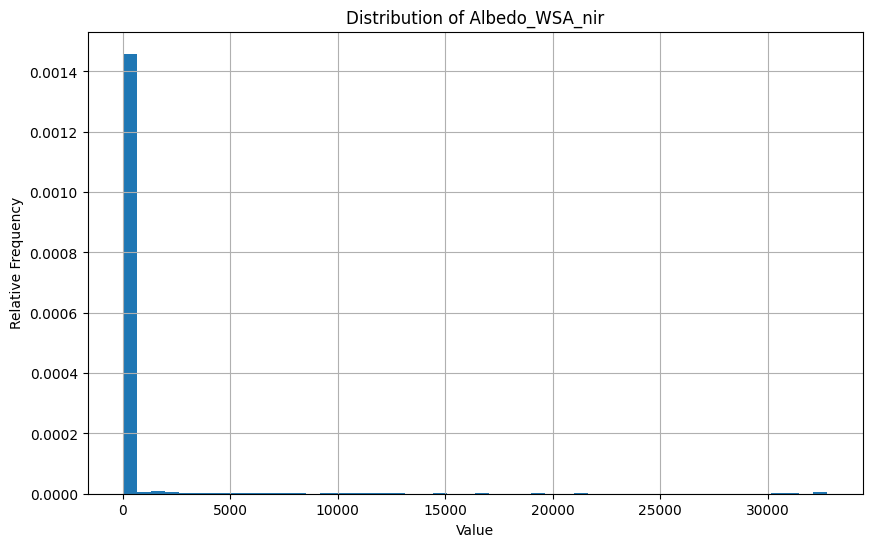

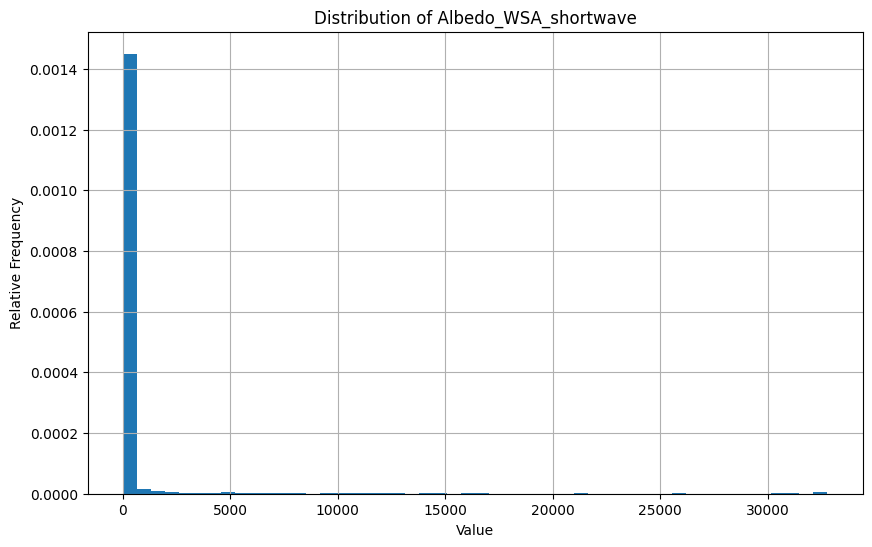

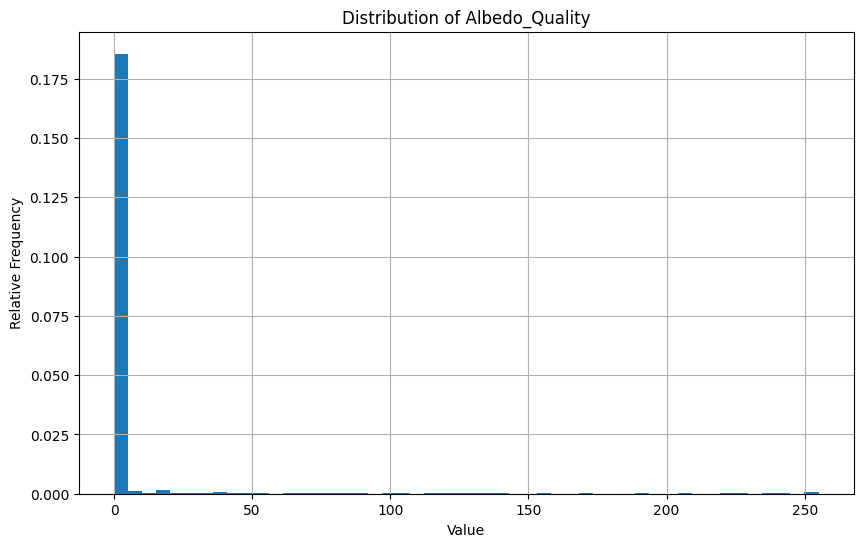

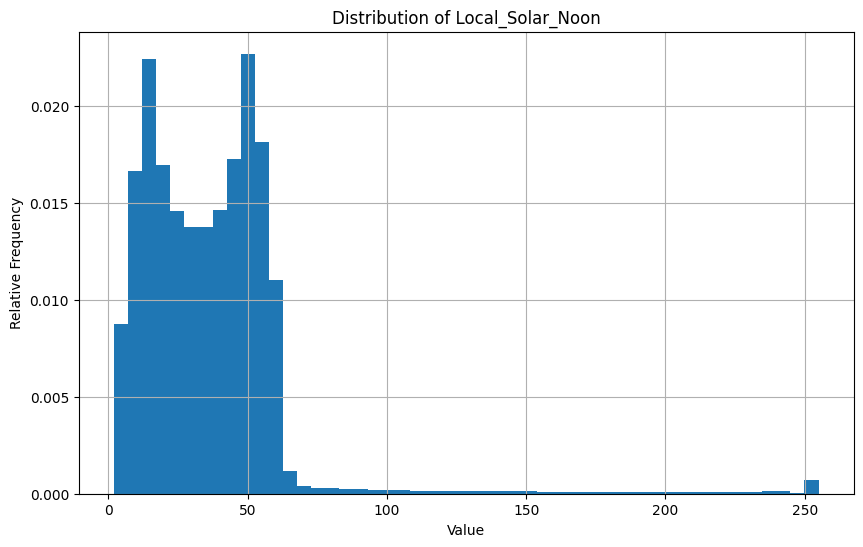

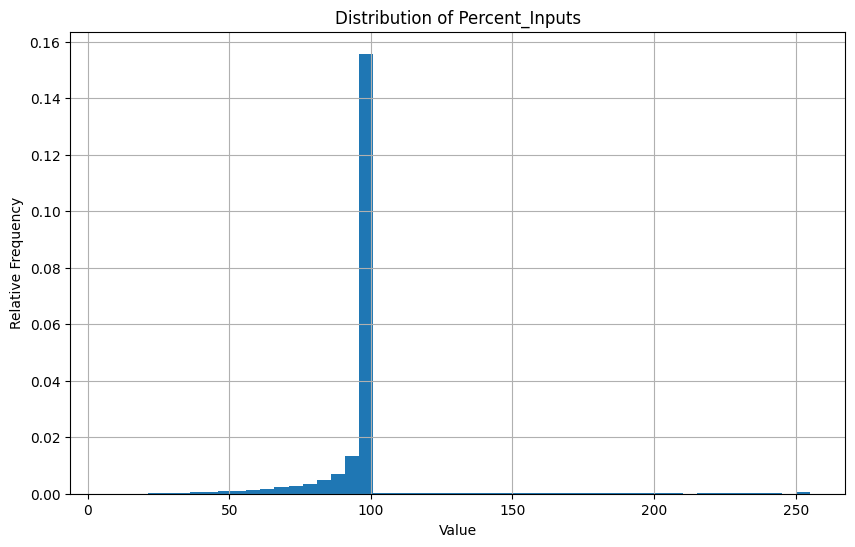

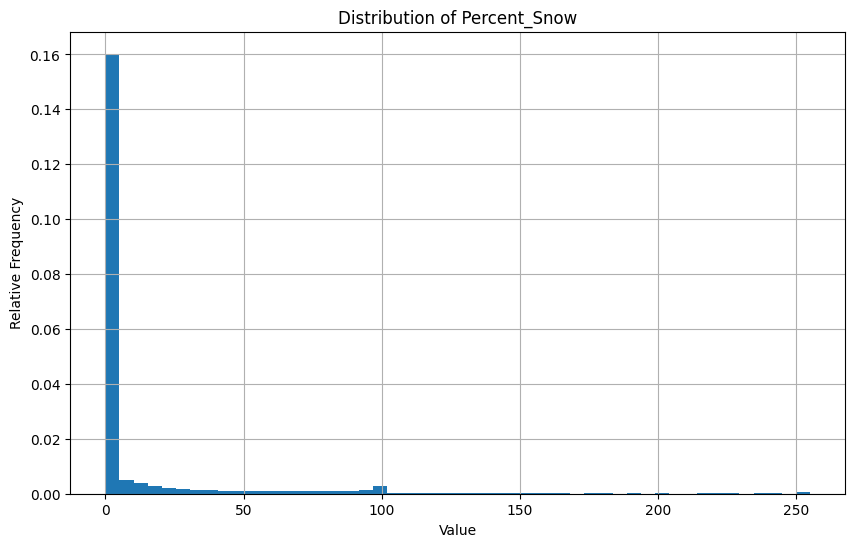

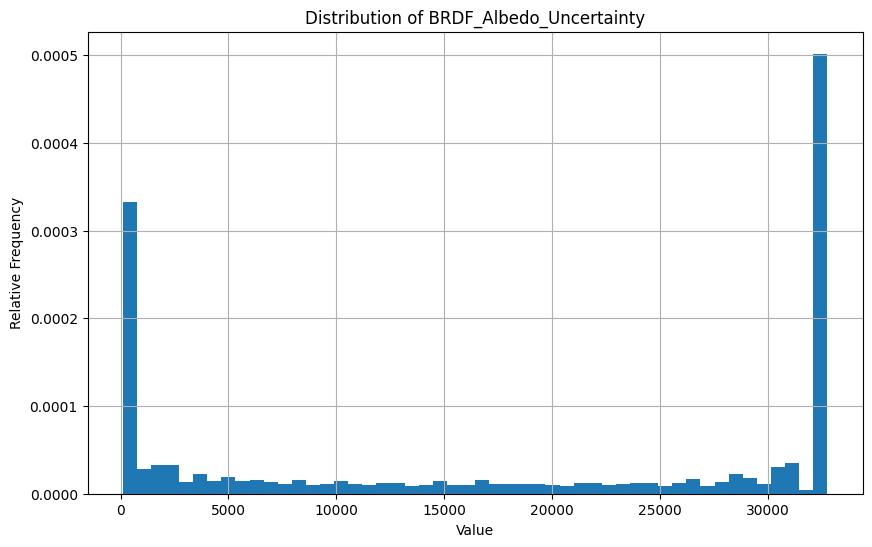

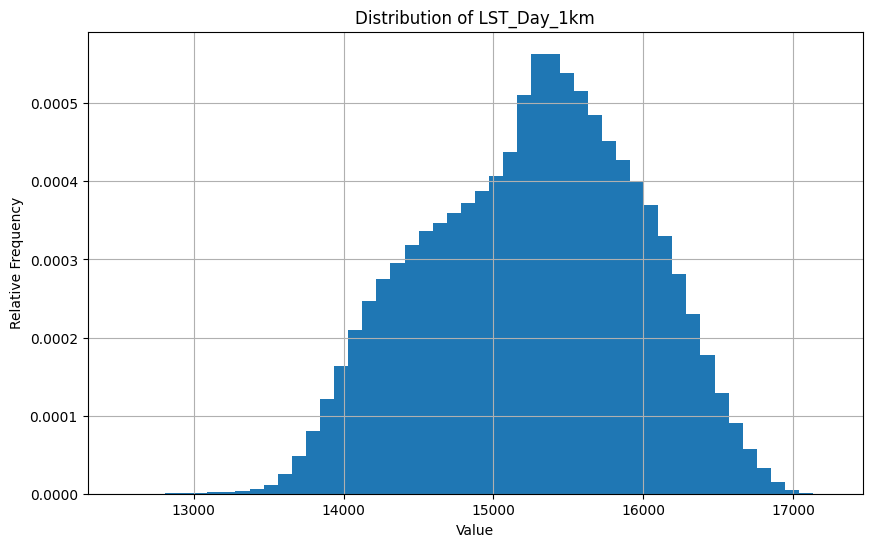

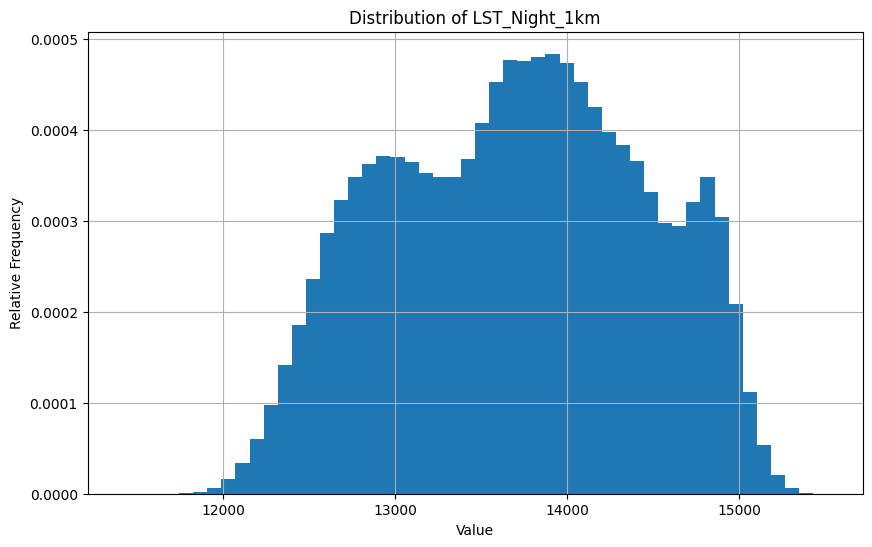

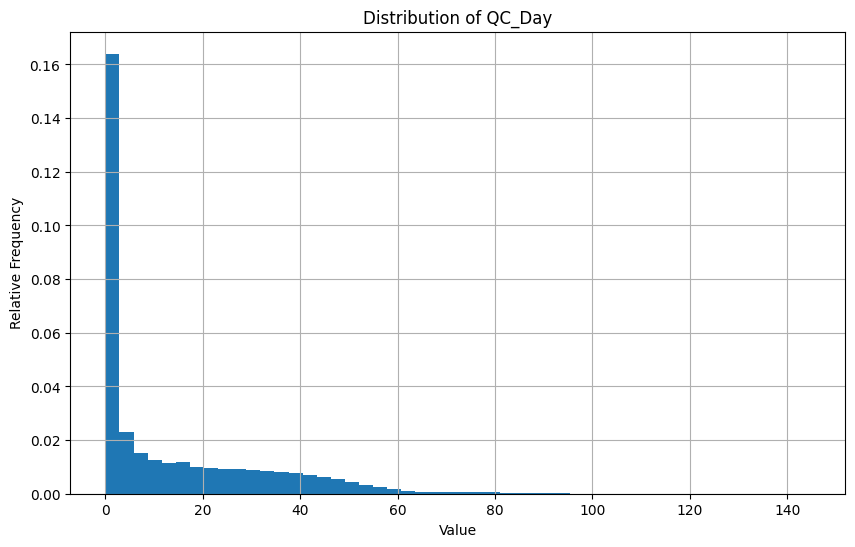

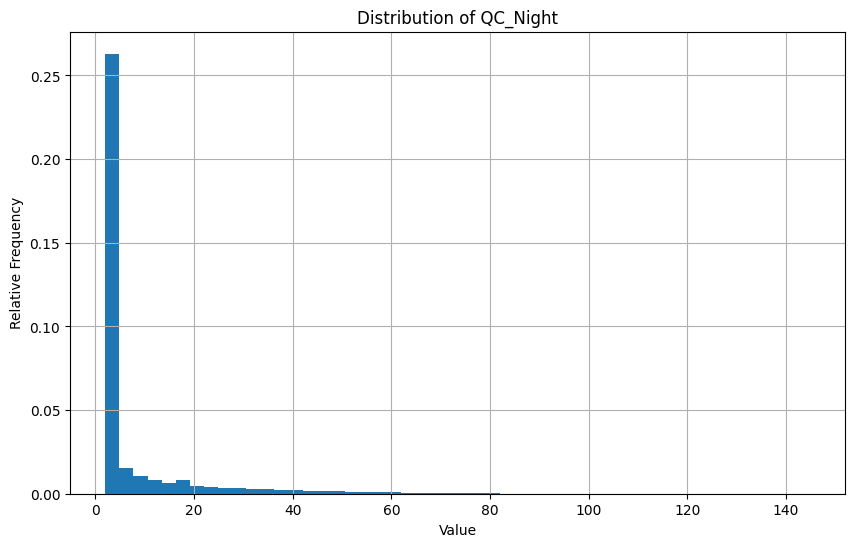

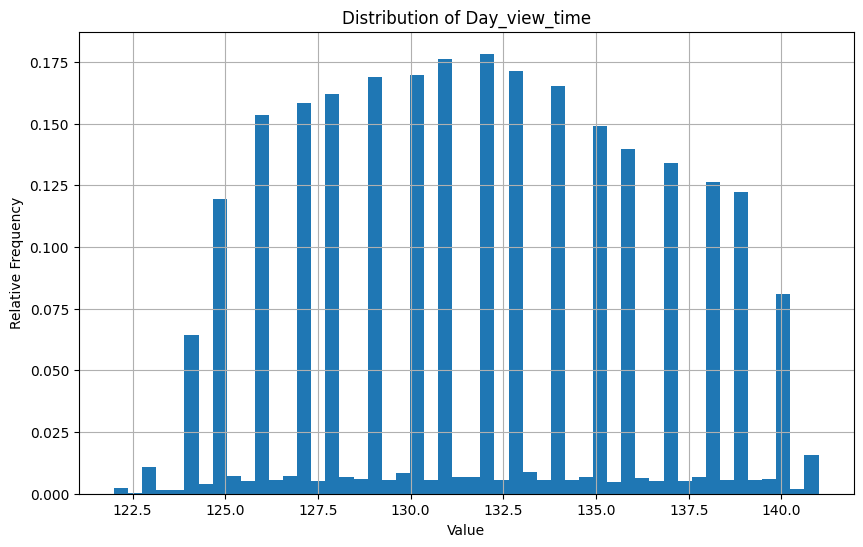

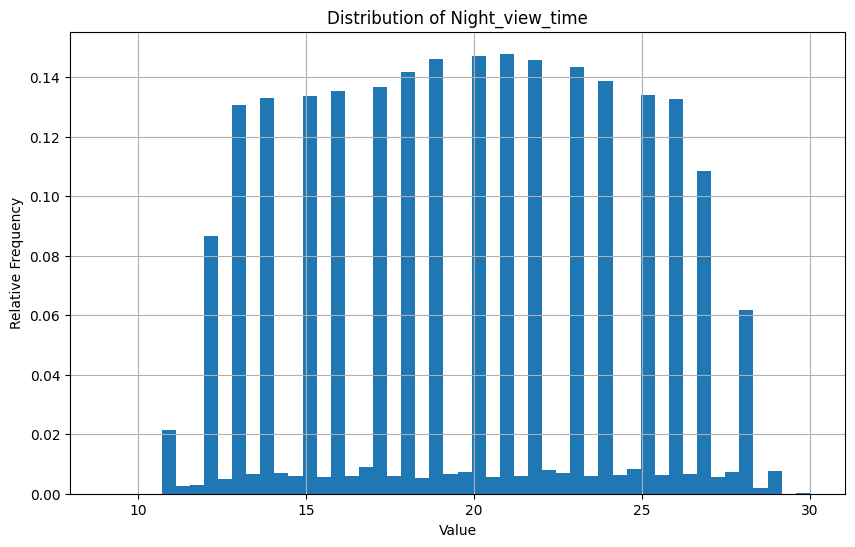

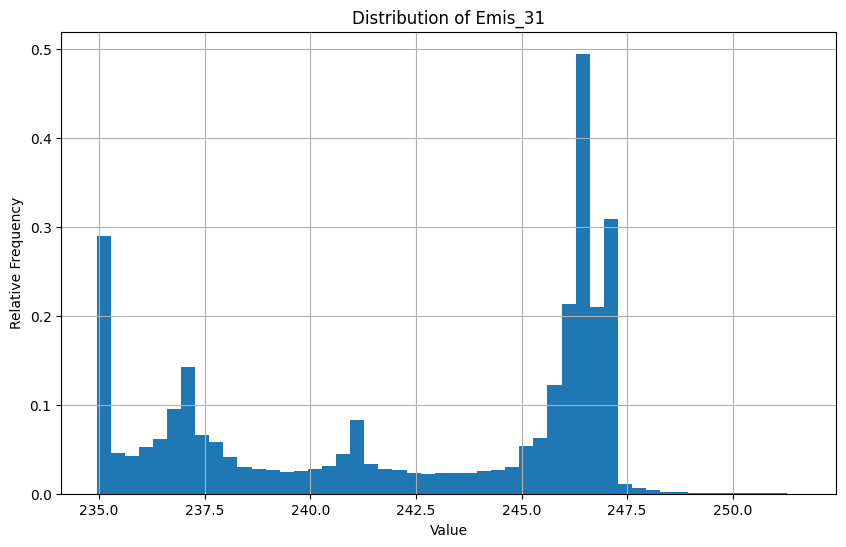

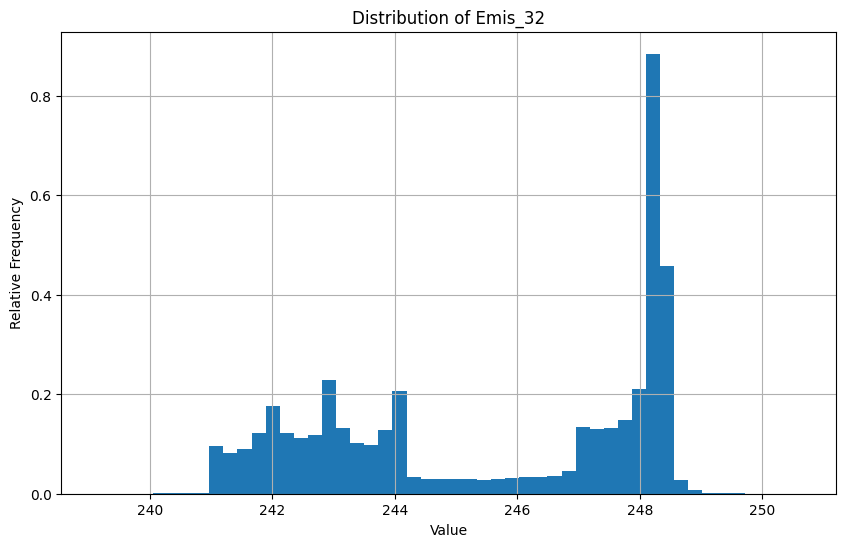

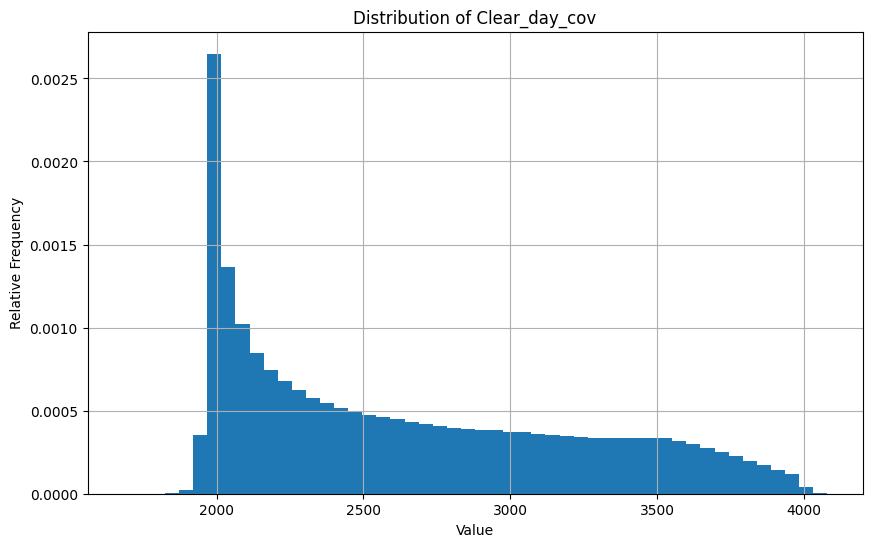

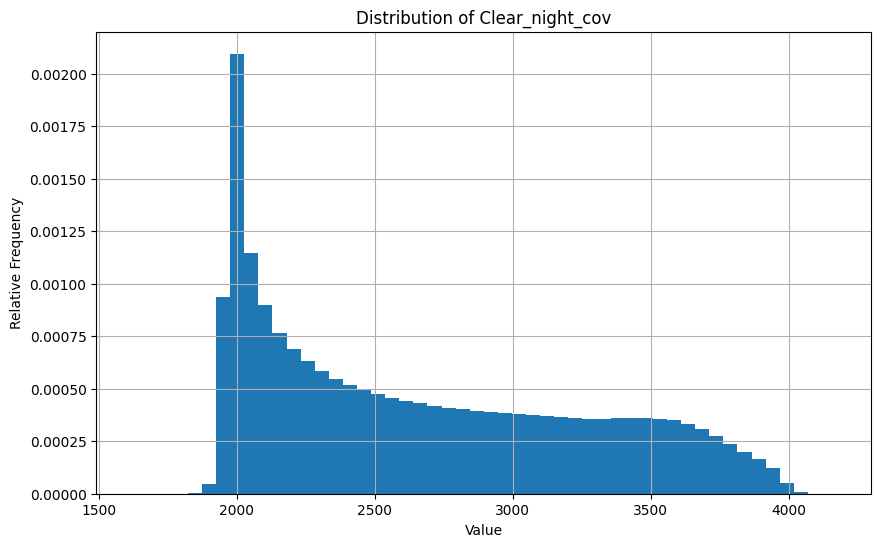

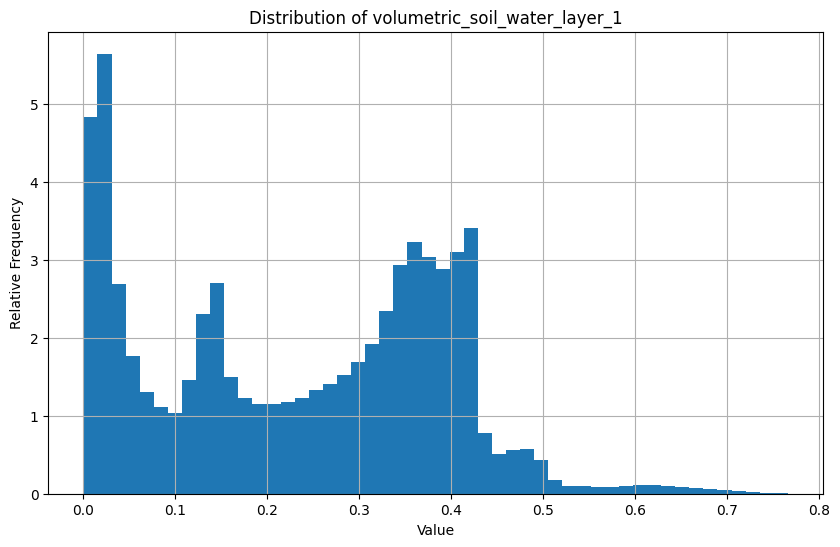

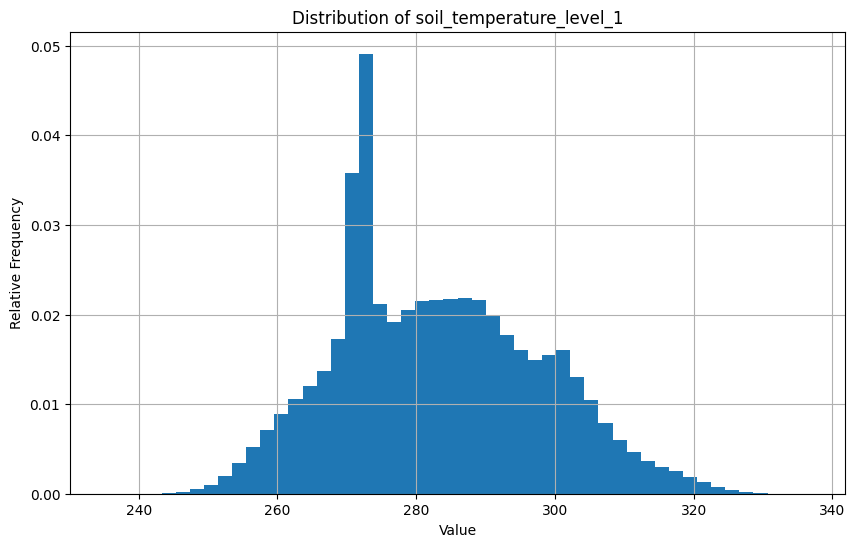

MemoryError: Unable to allocate 1.87 GiB for an array with shape (8768, 150, 381) and data type float32

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# 打开.nc文件
file_path = 'D:/Data_Store/Dataset/Original_Data/0.1_Data.nc'
data = xr.open_dataset(file_path)

# 循环每个变量并绘制直方图
for variable_name in data.data_vars:
    variable_data = data[variable_name]

    # Flatten the data for analysis
    flattened_data = variable_data.values.flatten()

    # Remove NaN values for plotting
    clean_data = flattened_data[~np.isnan(flattened_data)]

    # Skip if the variable has no valid data points
    if clean_data.size == 0:
        print(f"No valid data for variable '{variable_name}', skipping.")
        continue

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(clean_data, bins=50, density=True)  # Using density=True for relative frequency
    plt.title(f'Distribution of {variable_name}')
    plt.xlabel('Value')
    plt.ylabel('Relative Frequency')
    plt.grid(True)
    plt.show()


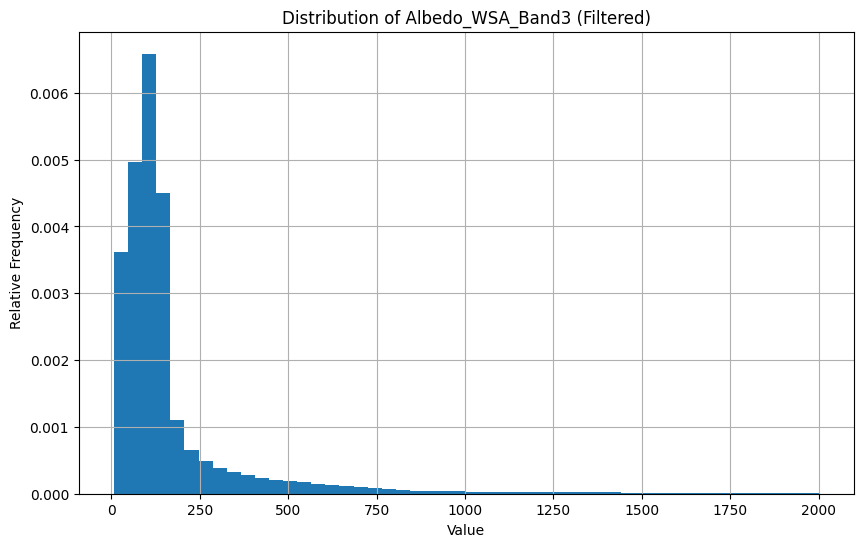

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# 打开.nc文件
file_path = 'D:/Data_Store/Dataset/Original_Data/0.37_Data.nc'
data = xr.open_dataset(file_path)

# 指定变量名
variable_name = "Albedo_WSA_Band3"  # 使用实际的变量名替换这里的占位符

# 获取变量数据
variable_data = data[variable_name]

# Flatten the data for analysis
flattened_data = variable_data.values.flatten()

# Remove NaN values and filter out values greater than 5000 for plotting
filtered_data = flattened_data[(~np.isnan(flattened_data)) & (flattened_data <= 2000)]

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=50, density=True)  # Using density=True for relative frequency
plt.title(f'Distribution of {variable_name} (Filtered)')
plt.xlabel('Value')
plt.ylabel('Relative Frequency')
plt.grid(True)
plt.show()


In [9]:
import xarray as xr
import numpy as np

# 打开.nc文件
file_path = 'D:/Data_Store/Dataset/Original_Data/0.37_Data.nc'
data = xr.open_dataset(file_path)

# 循环每个变量并计算NaN和0值的比例
for variable_name in data.data_vars:
    variable_data = data[variable_name]
    
    # Flatten the data for analysis
    flattened_data = variable_data.values.flatten()
    
    # Calculate the number of data points
    total_data_points = flattened_data.size
    
    # Calculate the number of missing data points (NaN)
    missing_data_points = np.isnan(flattened_data).sum()
    
    # Calculate the number of zeros
    zero_data_points = (flattened_data == 0).sum()
    
    # Calculate the missing rate and zero rate
    missing_rate = (missing_data_points / total_data_points) * 100
    zero_rate = (zero_data_points / total_data_points) * 100
    
    # Output the missing rate and zero rate for each variable
    print(f"Variable '{variable_name}': Missing Rate: {missing_rate:.2f}%, Zero Rate: {zero_rate:.2f}%")


Variable 'Albedo_BSA_Band1': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band2': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band3': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band4': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band5': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band6': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band7': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_vis': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_nir': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_shortwave': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_WSA_Band1': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_WSA_Band2': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_WSA_Band3': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_WSA_Band4': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_WSA_Band5': Missing Rate: 0.01%, Zero Rate: 0

In [10]:
import xarray as xr
import numpy as np

# 打开.nc文件
file_path = 'D:/Data_Store/Dataset/Original_Data/0.1_Data.nc'
data = xr.open_dataset(file_path)

# 循环每个变量并计算NaN和0值的比例
for variable_name in data.data_vars:
    variable_data = data[variable_name]
    
    # Flatten the data for analysis
    flattened_data = variable_data.values.flatten()
    
    # Calculate the number of data points
    total_data_points = flattened_data.size
    
    # Calculate the number of missing data points (NaN)
    missing_data_points = np.isnan(flattened_data).sum()
    
    # Calculate the number of zeros
    zero_data_points = (flattened_data == 0).sum()
    
    # Calculate the missing rate and zero rate
    missing_rate = (missing_data_points / total_data_points) * 100
    zero_rate = (zero_data_points / total_data_points) * 100
    
    # Output the missing rate and zero rate for each variable
    print(f"Variable '{variable_name}': Missing Rate: {missing_rate:.2f}%, Zero Rate: {zero_rate:.2f}%")


Variable 'Albedo_BSA_Band1': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band2': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band3': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band4': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band5': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band6': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_Band7': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_vis': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_nir': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_BSA_shortwave': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_WSA_Band1': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_WSA_Band2': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_WSA_Band3': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_WSA_Band4': Missing Rate: 0.01%, Zero Rate: 0.00%
Variable 'Albedo_WSA_Band5': Missing Rate: 0.01%, Zero Rate: 0

MemoryError: Unable to allocate 1.87 GiB for an array with shape (8768, 150, 381) and data type float32

In [6]:
import xarray as xr
import numpy as np

# 打开.nc文件
file_path = 'D:/Data_Store/Dataset/Original_Data/0.37_Data.nc'
data = xr.open_dataset(file_path)

# 循环每个以 "Albedo" 开头的变量并计算大于1000的值的比例
for variable_name in data.data_vars:
    if variable_name.startswith('Albedo'):  # 检查变量名是否以 "Albedo" 开头
        variable_data = data[variable_name]

        # Flatten the data for analysis
        flattened_data = variable_data.values.flatten()

        # Calculate the number of data points greater than 1000
        count_greater_than_1000 = (flattened_data > 10000).sum()

        # Calculate the total number of data points excluding NaN
        total_data_points = np.count_nonzero(~np.isnan(flattened_data))

        # Calculate the proportion
        proportion = (count_greater_than_1000 / total_data_points) * 100 if total_data_points > 0 else 0

        # Output the proportion for each variable
        print(f"Proportion of values greater than 1000 in variable '{variable_name}': {proportion:.2f}%")


Proportion of values greater than 1000 in variable 'Albedo_BSA_Band1': 1.77%
Proportion of values greater than 1000 in variable 'Albedo_BSA_Band2': 1.78%
Proportion of values greater than 1000 in variable 'Albedo_BSA_Band3': 1.79%
Proportion of values greater than 1000 in variable 'Albedo_BSA_Band4': 1.77%
Proportion of values greater than 1000 in variable 'Albedo_BSA_Band5': 1.78%
Proportion of values greater than 1000 in variable 'Albedo_BSA_Band6': 2.14%
Proportion of values greater than 1000 in variable 'Albedo_BSA_Band7': 1.76%
Proportion of values greater than 1000 in variable 'Albedo_BSA_vis': 1.80%
Proportion of values greater than 1000 in variable 'Albedo_BSA_nir': 1.77%
Proportion of values greater than 1000 in variable 'Albedo_BSA_shortwave': 1.80%
Proportion of values greater than 1000 in variable 'Albedo_WSA_Band1': 1.77%
Proportion of values greater than 1000 in variable 'Albedo_WSA_Band2': 1.78%
Proportion of values greater than 1000 in variable 'Albedo_WSA_Band3': 1.79%

In [6]:
import numpy as np

# Load the mean and std arrays
mean1 = np.load("D:\Data_Store\Dataset\ST_Conv\std_mean\mean.npy", allow_pickle=True)
std1 = np.load("D:\Data_Store\Dataset\ST_Conv\std_mean\std.npy", allow_pickle=True)

mean2 = np.load("D:\Data_Store\Dataset\ST_Conv\std_mean\mean_dict.npy", allow_pickle=True)
std2 = np.load("D:\Data_Store\Dataset\ST_Conv\std_mean\std_dict.npy", allow_pickle=True)

mean3 = np.load(r"D:\Data_Store\Dataset\LSTM\Nor\mean.npy", allow_pickle=True)
std3 = np.load(r"D:\Data_Store\Dataset\LSTM\Nor\std.npy", allow_pickle=True)

print(mean1)
print(std1)
print(mean2)
print(std2)
print(mean3)
print(std3)

[ 2.04123551e-01  1.79877073e-01  2.61804663e+03  1.76590439e+02
  8.94298248e+01  3.86167236e+02  2.21331680e+02  3.59731018e+02
  3.19856293e+02  2.83487000e+02 -4.94556443e-05  5.54046812e+05
 -3.04284438e+05 -1.24365945e+05 -1.20462867e+05  1.55942744e+04
  1.40569834e+04  7.06585327e+02  7.90331970e+02  6.44408081e+02
  6.81043823e+02  7.92311646e+02  8.71277344e+02  7.09981567e+02
  6.76027832e+02  7.61014954e+02  7.23080383e+02  6.84210205e+02
  7.76848450e+02  7.34443359e+02  7.16695801e+02  8.08901428e+02
  6.50396973e+02  6.90634277e+02  8.10334473e+02  8.86255615e+02
  7.19805054e+02  2.52553857e+03  1.51052319e+03  8.60794444e+01
  3.29491542e+01  4.38250730e+03]
[1.36186335e-01 7.55496204e-01 1.84436975e+03 1.04637709e+01
 1.33402944e+00 9.09530945e+01 5.72458649e+01 6.70320892e+01
 2.39688202e+02 1.45679607e+01 9.43949999e-05 7.48309438e+05
 1.74767547e+05 2.36234828e+05 2.41605703e+05 5.68719604e+02
 6.90477356e+02 2.80051587e+03 2.79224976e+03 2.83084131e+03
 2.80217700